In [1]:
# Train Time Series Prediction Model from end to end
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Read the data
csv_path = 'data/raw_weekly_hospital_respiratory_data_2020_2024.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows to verify
df.head()

Week Ending Date Geographic aggregation  Number of Inpatient Beds  \
0       2023-08-12                     WA                   10650.0   
1       2023-08-12                     WI                   10752.0   
2       2023-08-12                     WV                    4813.0   
3       2023-08-12                     WY                    1318.0   
4       2023-08-19                     AK                    1354.0   

   Number of Adult Inpatient Beds  Number of Pediatric Inpatient beds  \
0                          9282.0                               482.0   
1                          9824.0                               425.0   
2                          4556.0                               256.0   
3                          1142.0                                25.0   
4                          1192.0                                77.0   

   Number of Inpatient Beds Occupied  Number of Adult Inpatient Beds Occupied  \
0                             9040.0                                   8117.0   
1                             7574.0                                   7027.0   
2                             3701.0                                   3562.0   
3                              559.0                                    534.0   
4                             1054.0                                    939.0   

   Number of Pediatric Inpatient Beds Occupied  Number of ICU Beds  \
0                                        339.0              1623.0   
1                                        286.0              1566.0   
2                                        139.0               639.0   
3                                          6.0               114.0   
4                                         43.0               184.0   

   Number of Adult ICU Beds  ...  \
0                    1059.0  ...   
1                    1232.0  ...   
2                     595.0  ...   
3                     109.0  ...   
4                     126.0  ...   

   Absolute Change in the Percent Hospitals Reporting Adult RSV Admissions from Prior Week  \
0                                                0.0                                         
1                                                0.0                                         
2                                                0.0                                         
3                                                0.0                                         
4                                                0.0                                         

   Absolute Change in the Percent Hospitals Reporting RSV Admissions from Prior Week  \
0                                                0.0                                   
1                                                0.0                                   
2                                                0.0                                   
3                                                0.0                                   
4                                                0.0                                   

   Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied from Prior Week  \
0                                               0.00                                                    
1                                               0.00                                                    
2                                               0.00                                                    
3                                               0.03                                                    
4                                               0.00                                                    

   Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied from Prior Week  \
0                                               0.00                                              
1                                               0.00                                    

In [3]:
# Subset the data to only keeps prediction features
# Search for columns containing 'Total ICU Patients Hospitalized'
matching_columns = [col for col in df.columns if 'Total ICU Patients Hospitalized' in col]
print("Matching Columns:", matching_columns)

Matching Columns: ['Total ICU Patients Hospitalized with COVID-19 ', 'Total ICU Patients Hospitalized with Influenza', 'Total ICU Patients Hospitalized with RSV']


In [4]:
# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

for idx, column in enumerate(df.columns, 1):
    print(f"{idx}: {column}")

1: Week Ending Date
2: Geographic aggregation
3: Number of Inpatient Beds
4: Number of Adult Inpatient Beds
5: Number of Pediatric Inpatient beds
6: Number of Inpatient Beds Occupied
7: Number of Adult Inpatient Beds Occupied
8: Number of Pediatric Inpatient Beds Occupied
9: Number of ICU Beds
10: Number of Adult ICU Beds
11: Number of Pediatric ICU Beds
12: Number of ICU Beds Occupied
13: Number of Adult ICU Beds Occupied
14: Number of Pediatric ICU Beds Occupied
15: Number of Adult Patients Hospitalized with COVID-19
16: Number of Pediatric Patients Hospitalized with COVID-19
17: Total Patients Hospitalized with COVID-19
18: Number of Adult Patients Hospitalized with Influenza
19: Number of Pedatric Patients Hospitalized with Influenza
20: Total Patients Hospitalized with Influenza
21: Number of Adult Patients Hospitalized with RSV
22: Number of Pediatric Patients Hospitalized with RSV
23: Total Patients Hospitalized with RSV
24: Number of Adult ICU Patients Hospitalized with COVID-1

In [ ]:
# Subset the data, correct approach is to use double square brackets [[ ]] and pass a list of column names.
df_t = df[['Week Ending Date','Geographic aggregation','Total Patients Hospitalized with COVID-19']]
df_t.head()

Week Ending Date Geographic aggregation  \
0       2023-08-12                     WA   
1       2023-08-12                     WI   
2       2023-08-12                     WV   
3       2023-08-12                     WY   
4       2023-08-19                     AK   

   Total Patients Hospitalized with COVID-19  
0                                      226.0  
1                                       86.0  
2                                       47.0  
3                                        4.0  
4                                       12.0

In [7]:
# Impute missing value
df_t.isnull().sum()

Week Ending Date                               0
Geographic aggregation                         0
Total Patients Hospitalized with COVID-19    260
dtype: int64

In [ ]:
# Check the distribution of missing values by the geographic categorical column
missing_distribution = df.groupby('Geographic aggregation')['Total Patients Hospitalized with COVID-19'].apply(lambda x: x.isnull().sum())

# Display the result
print(missing_distribution.sort_values(ascending=False))

# MP     124
# AS      77
# VI      19
# MA      17
# MN      14
# WV       5

Geographic aggregation
MP     124
AS      77
VI      19
MA      17
MN      14
WV       5
GU       4
AK       0
NY       0
OK       0
OH       0
NM       0
NV       0
PA       0
NJ       0
NH       0
OR       0
SC       0
PR       0
RI       0
ND       0
SD       0
TN       0
TX       0
USA      0
UT       0
VA       0
VT       0
WA       0
WI       0
NE       0
MS       0
NC       0
IA       0
AR       0
AZ       0
CA       0
CO       0
CT       0
DC       0
DE       0
FL       0
GA       0
HI       0
ID       0
MT       0
IL       0
IN       0
KS       0
KY       0
LA       0
MD       0
ME       0
MI       0
MO       0
AL       0
WY       0
Name: Total Patients Hospitalized with COVID-19, dtype: int64


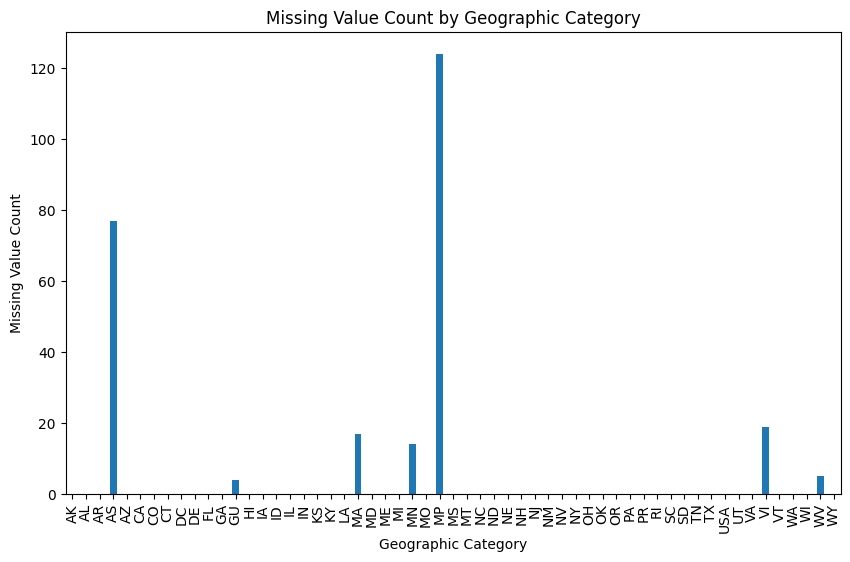

In [12]:
# Create a bar chart for missing value count
missing_distribution.plot(kind='bar', figsize=(10, 6), title="Missing Value Count by Geographic Category")
plt.xlabel('Geographic Category')
plt.ylabel('Missing Value Count')
plt.show()

In [14]:
# Since only 6 states with missing value, I will just use combination of ffill and bfill
# Imputation on Total ICU Patients Hospitalized with COVID-19
df_t = df_t.sort_values(['Geographic aggregation', 'Week Ending Date'])

# Apply forward fill and backward fill within each geographic group
df_t['COVID-19 Inpatients'] = (
    df_t
    .groupby('Geographic aggregation')['Total Patients Hospitalized with COVID-19']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

# Display the DataFrame after imputation
print("DataFrame After Grouped Imputation:")
df_t.head(100)

DataFrame After Grouped Imputation:


/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_24249/411442643.py:9: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  .fillna(method='ffill')
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_24249/411442643.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_24249/411442643.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


Week Ending Date Geographic aggregation  \
3766       2020-08-08                     AK   
3823       2020-08-15                     AK   
3880       2020-08-22                     AK   
3937       2020-08-29                     AK   
3994       2020-09-05                     AK   
...               ...                    ...   
9181       2022-06-04                     AK   
9238       2022-06-11                     AK   
9295       2022-06-18                     AK   
9352       2022-06-25                     AK   
9409       2022-07-02                     AK   

      Total Patients Hospitalized with COVID-19  COVID-19 Inpatients  
3766                                       52.0                 52.0  
3823                                       59.0                 59.0  
3880                                       72.0                 72.0  
3937                                       67.0                 67.0  
3994                                       68.0                 68.0  
...                                         ...                  ...  
9181                                       41.0                 41.0  
9238                                       46.0                 46.0  
9295                                       54.0                 54.0  
9352                                       60.0                 60.0  
9409                                       67.0                 67.0  

[100 rows x 4 columns]

In [ ]:
# Train Time Series Model
# 1. Load and Inspect Data
# Convert 'Week Ending Date' to datetime format
df_t['Week Ending Date'] = pd.to_datetime(df_t['Week Ending Date'])

# Sort the DataFrame by 'Geographic aggregation' and 'Week Ending Date'
df_t = df_t.sort_values(['Geographic aggregation', 'Week Ending Date'])

# Set 'Week Ending Date' as the index for time series operations
df_t.set_index('Week Ending Date', inplace=True)

In [16]:
# Feature engineering

# Create lag features (e.g., past 4 weeks)
lag_steps = [1, 2, 3, 4]
for lag in lag_steps:
    df_t[f'lag_{lag}'] = df_t.groupby('Geographic aggregation')['COVID-19 Inpatients'].shift(lag)

# Create rolling mean feature (e.g., 2-week rolling mean)
df_t['rolling_mean_2'] = df_t.groupby('Geographic aggregation')['COVID-19 Inpatients'].transform(lambda x: x.rolling(window=2).mean())

# Drop rows with any remaining NaNs due to lagging or rolling
df_model = df_t.dropna()
print(df_model.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12284 entries, 2020-09-05 to 2024-11-16
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Geographic aggregation                     12284 non-null  object 
 1   Total Patients Hospitalized with COVID-19  12284 non-null  float64
 2   COVID-19 Inpatients                        12284 non-null  float64
 3   lag_1                                      12284 non-null  float64
 4   lag_2                                      12284 non-null  float64
 5   lag_3                                      12284 non-null  float64
 6   lag_4                                      12284 non-null  float64
 7   rolling_mean_2                             12284 non-null  float64
dtypes: float64(7), object(1)
memory usage: 863.7+ KB
None


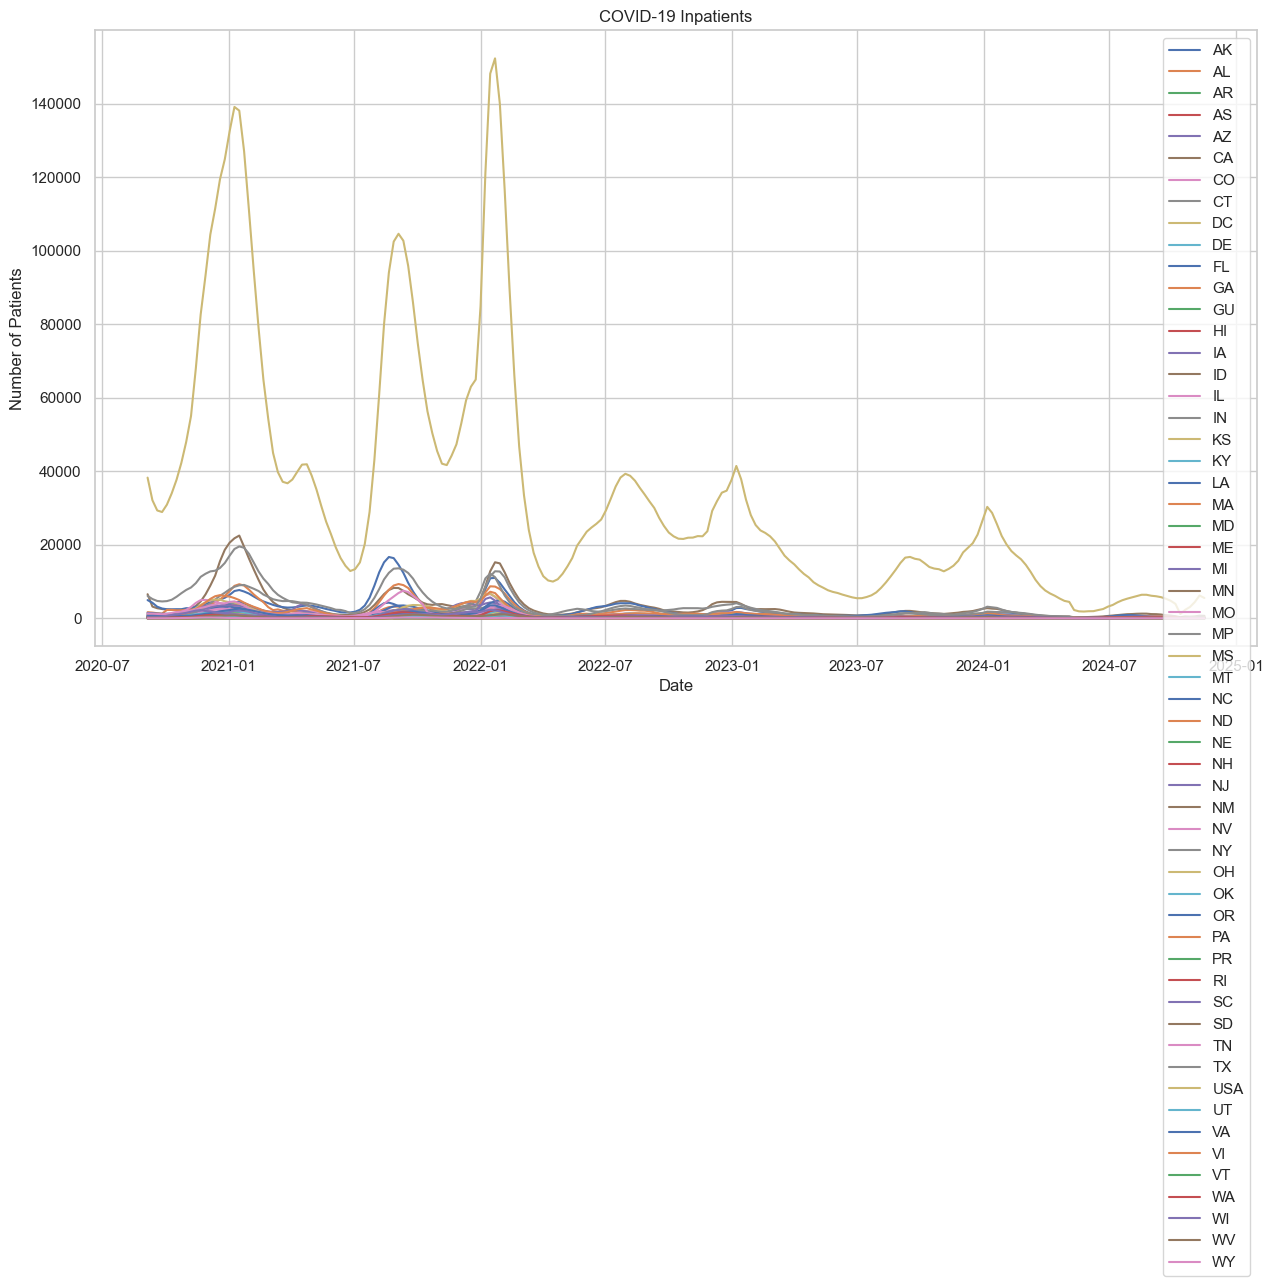

In [17]:
# 2. Exploratory Data Analysis (EDA)
# Set the visual style
sns.set(style="whitegrid")

# Identify unique regions
regions = df_model['Geographic aggregation'].unique()

# Plot time series for each region
plt.figure(figsize=(15, 8))
for region in regions:
    plt.plot(df_model[df_model['Geographic aggregation'] == region].index, 
             df_model[df_model['Geographic aggregation'] == region]['COVID-19 Inpatients'], 
             label=region)

plt.title('COVID-19 Inpatients')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

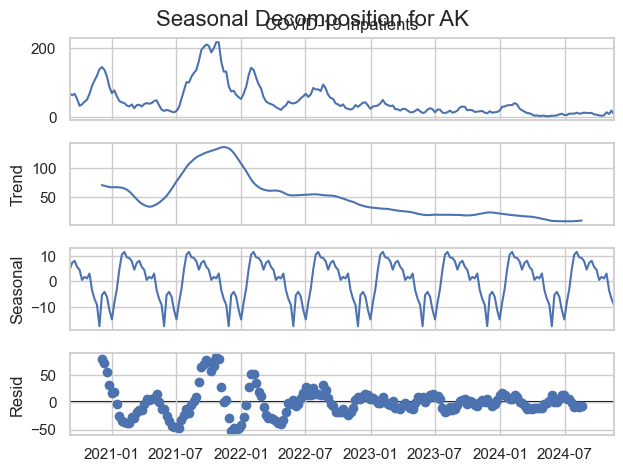

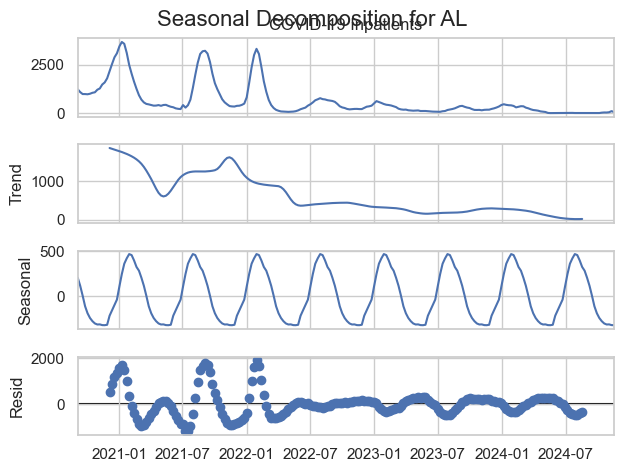

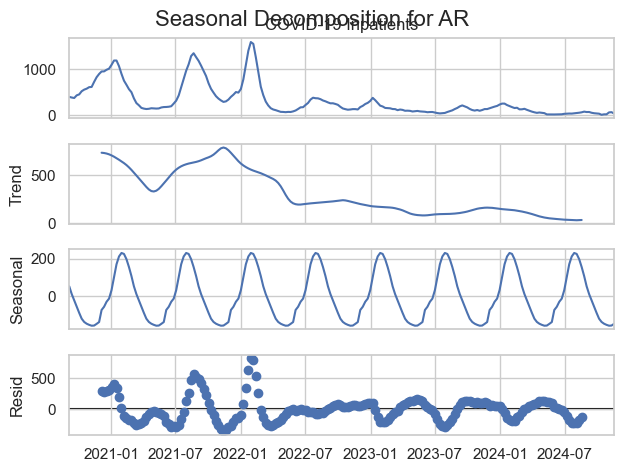

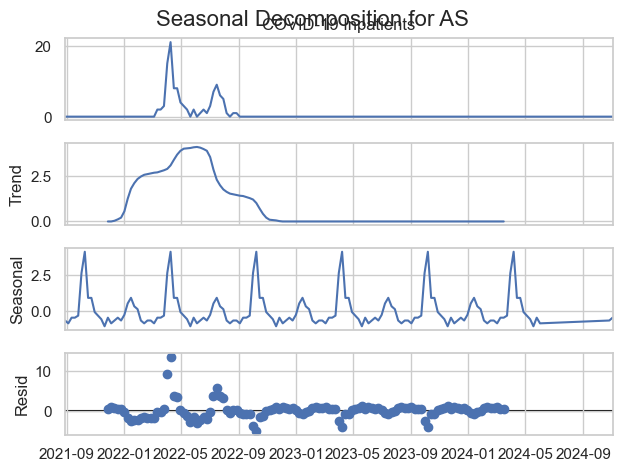

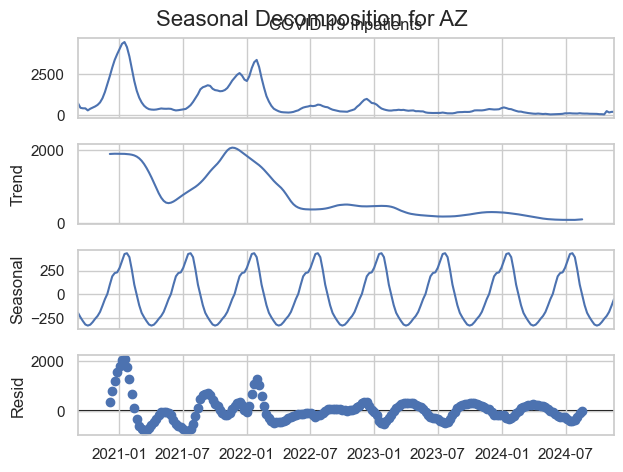

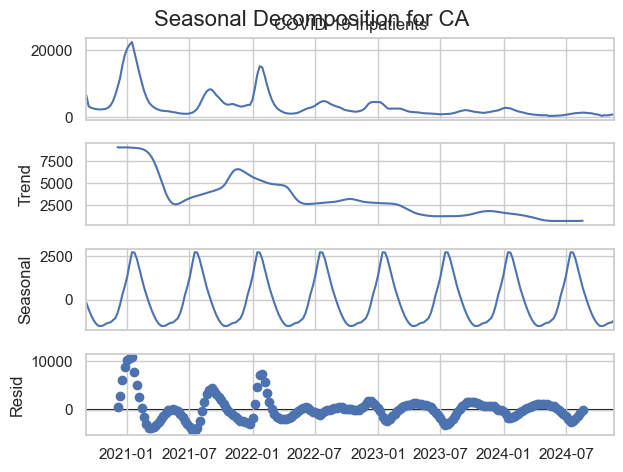

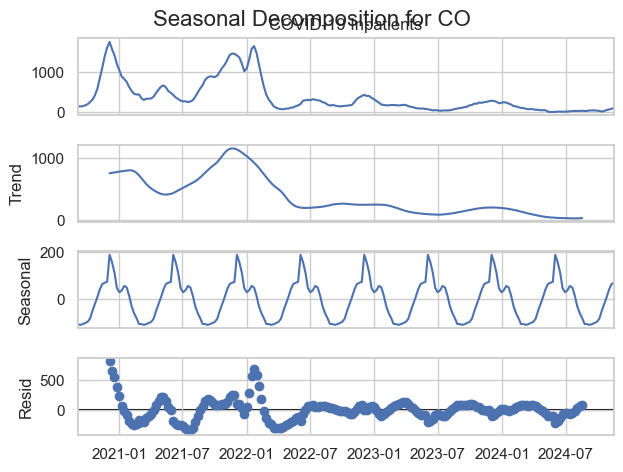

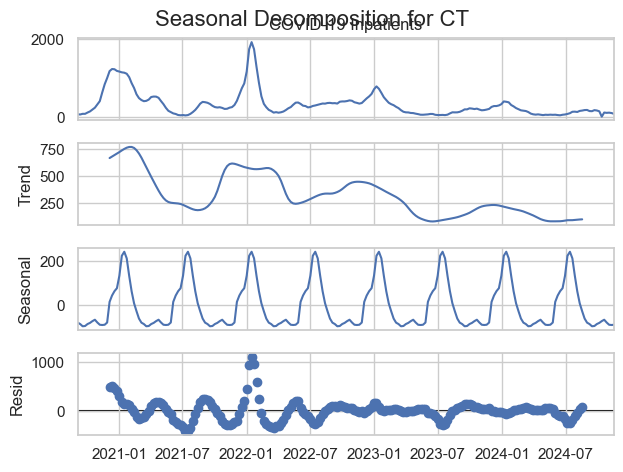

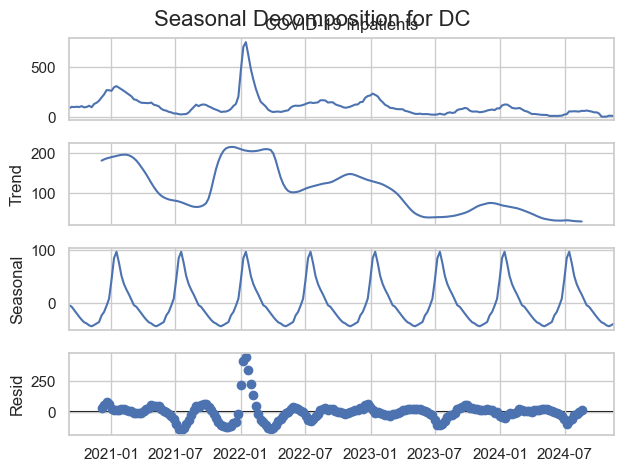

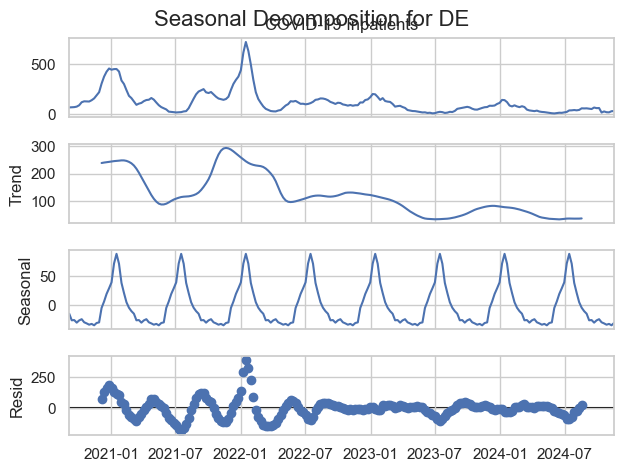

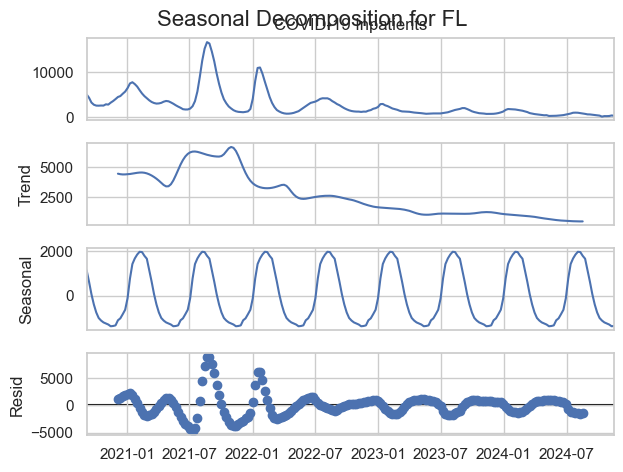

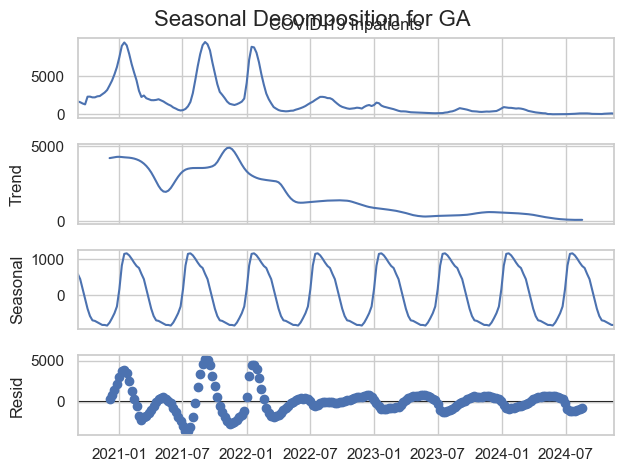

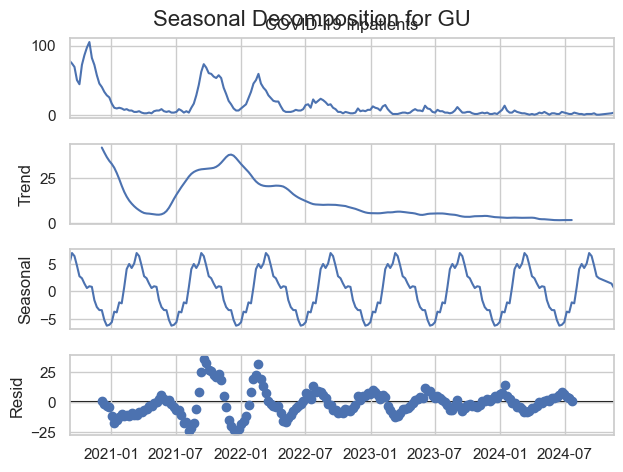

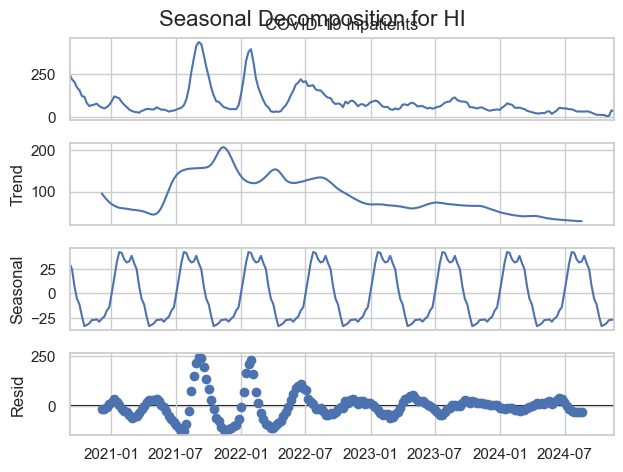

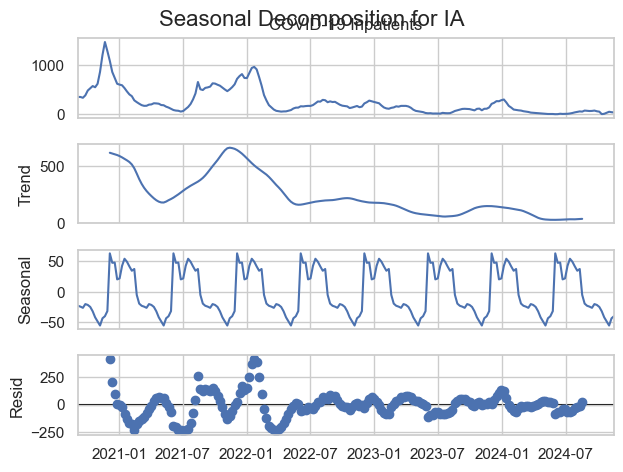

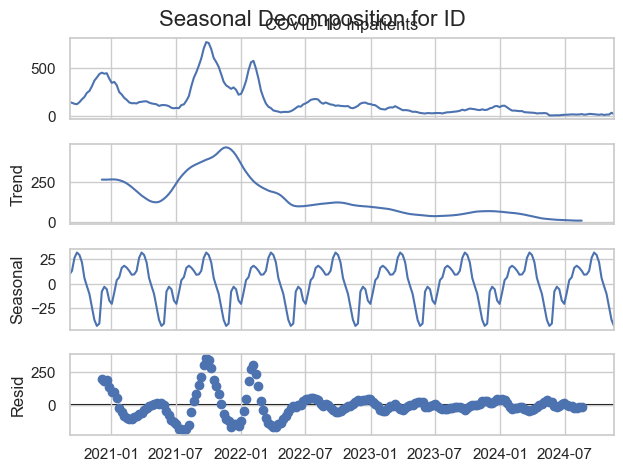

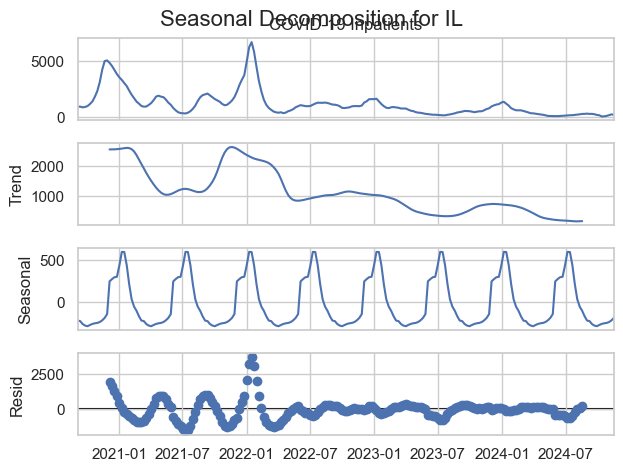

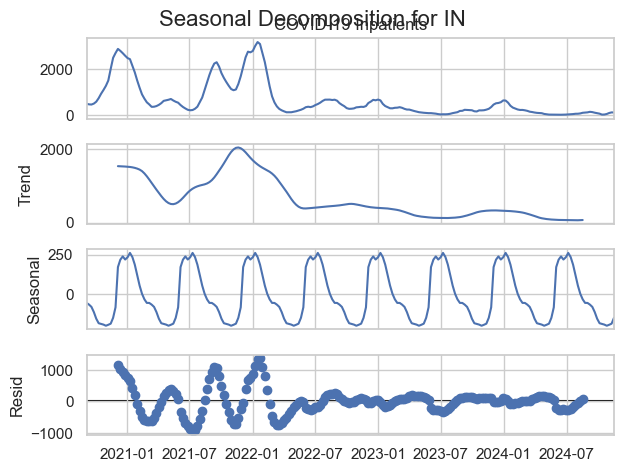

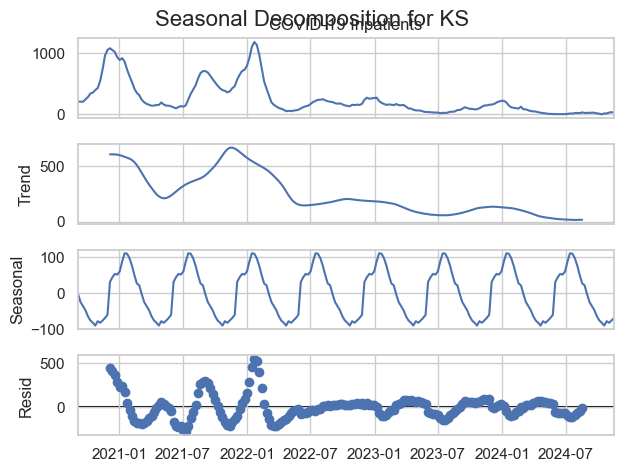

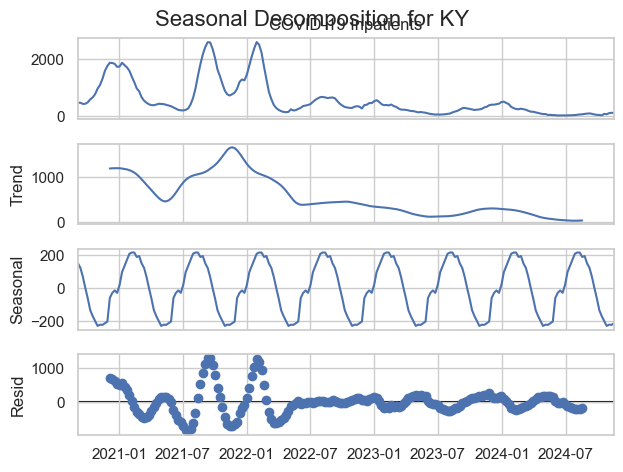

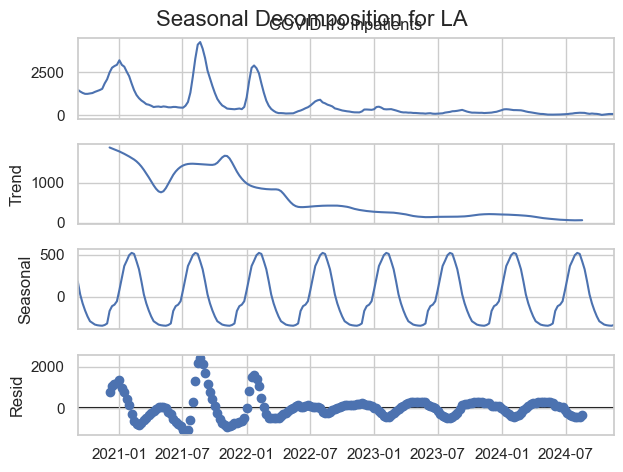

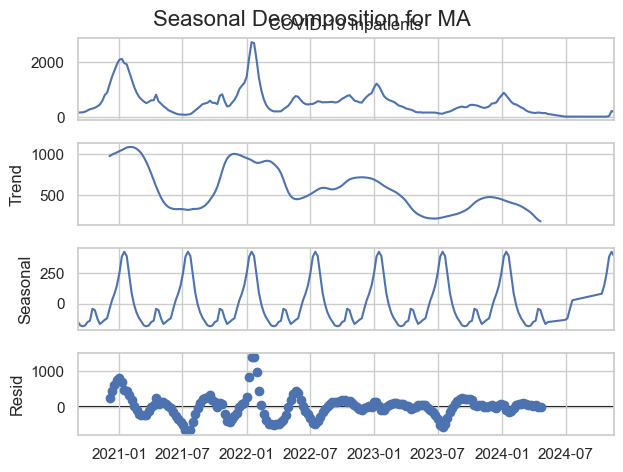

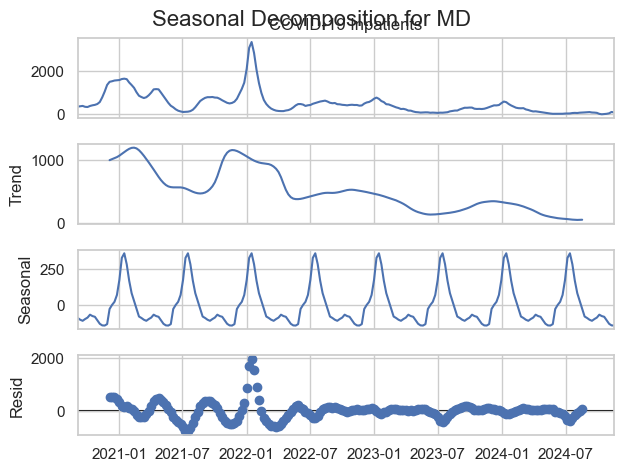

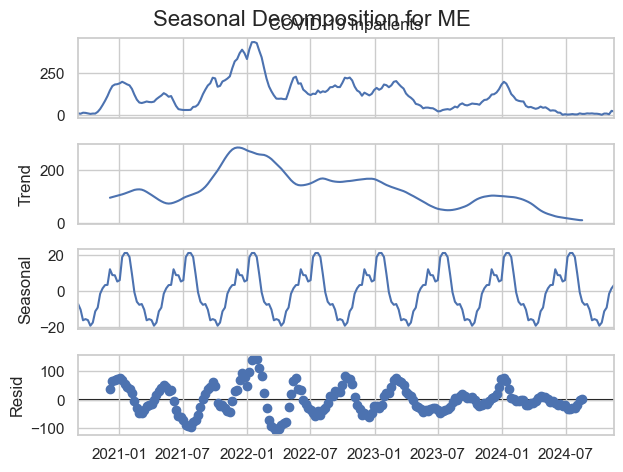

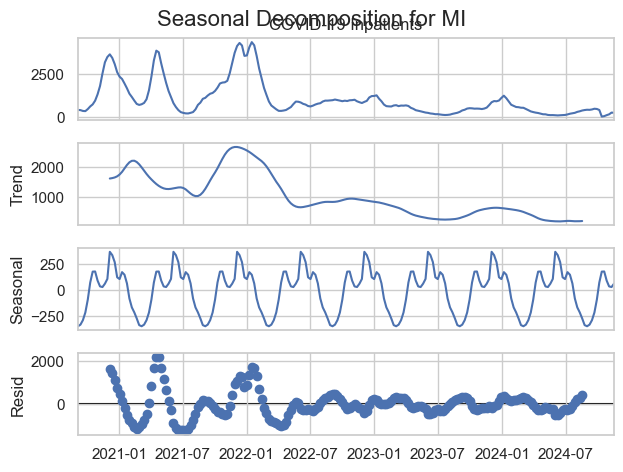

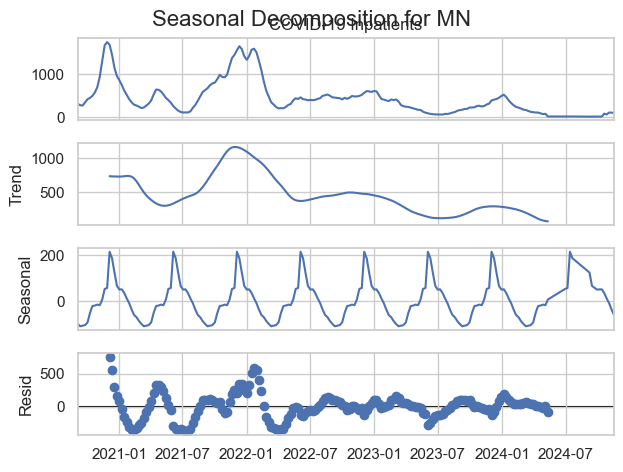

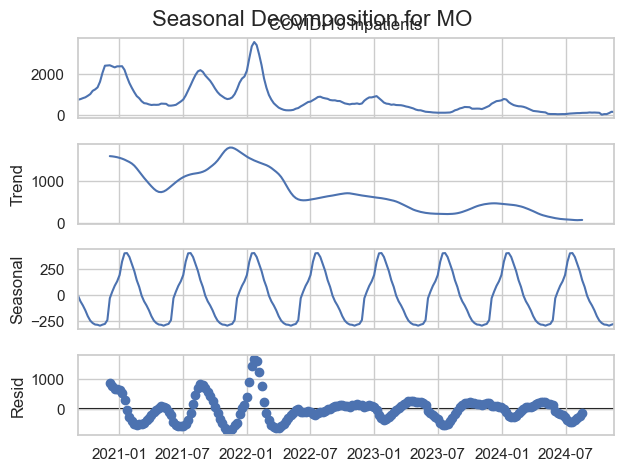

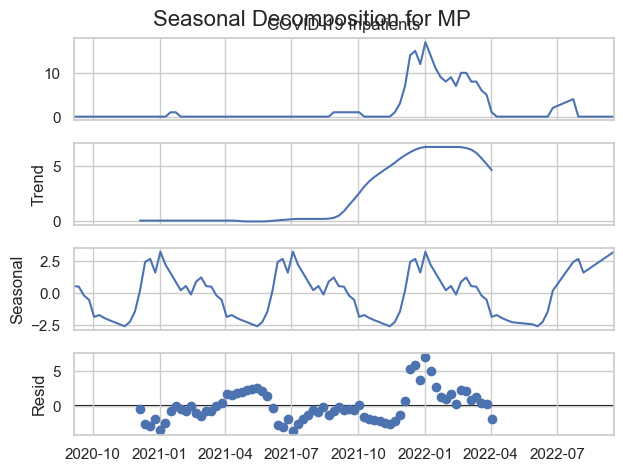

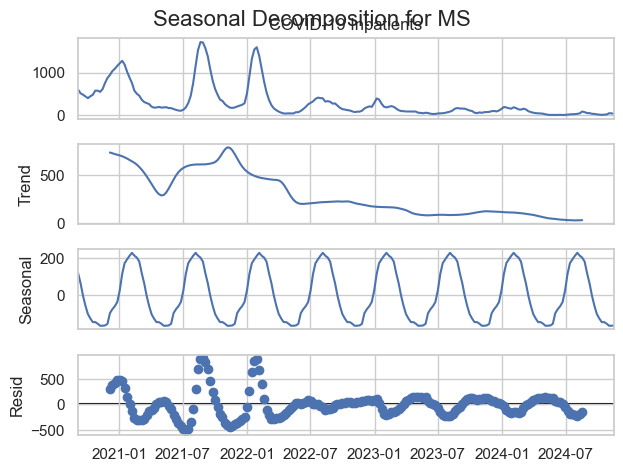

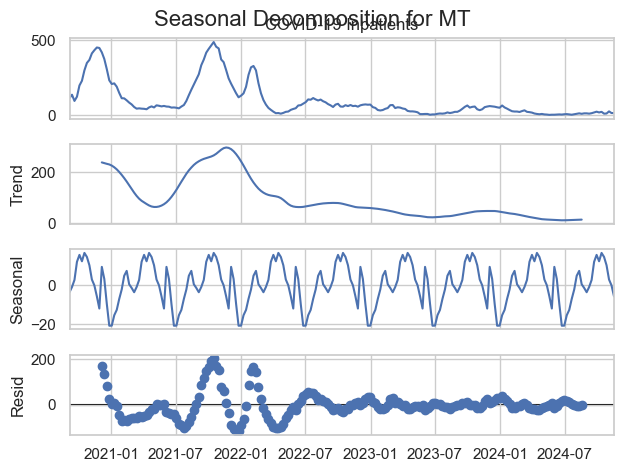

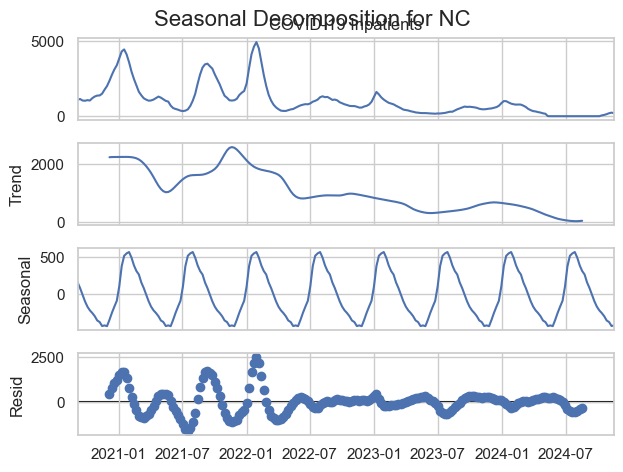

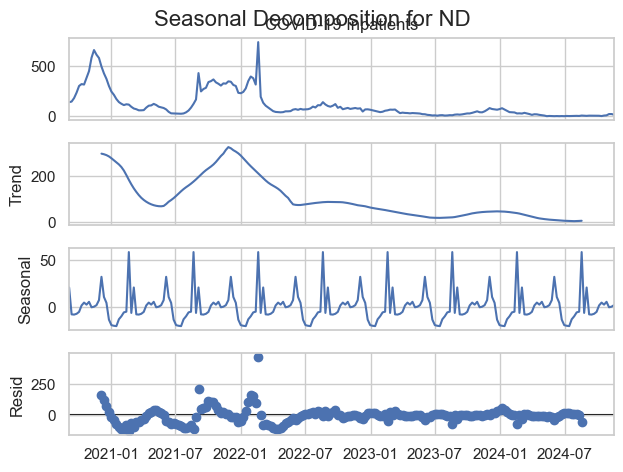

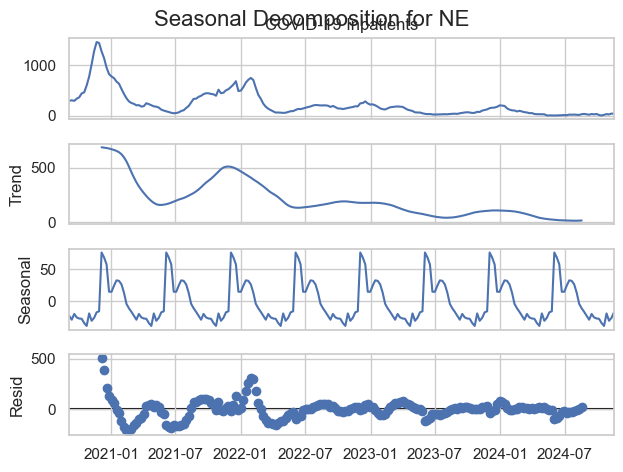

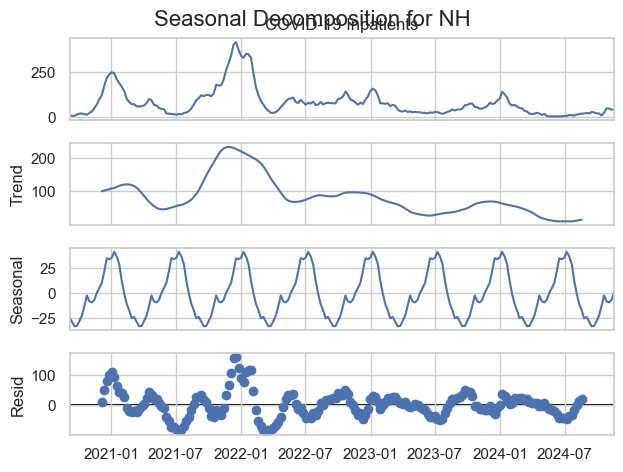

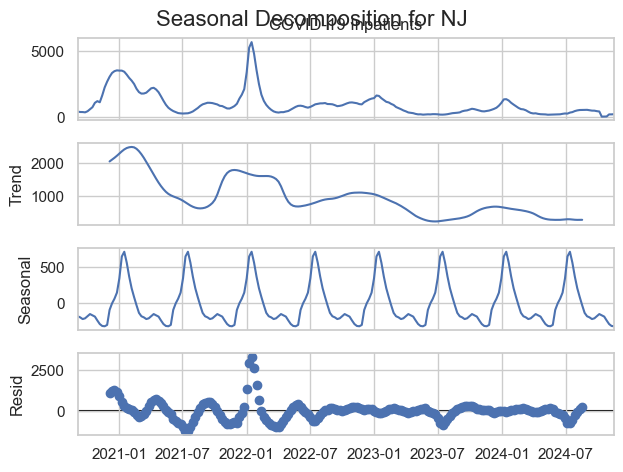

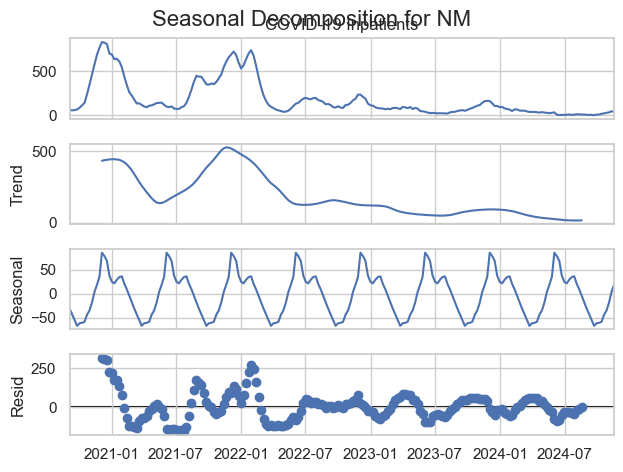

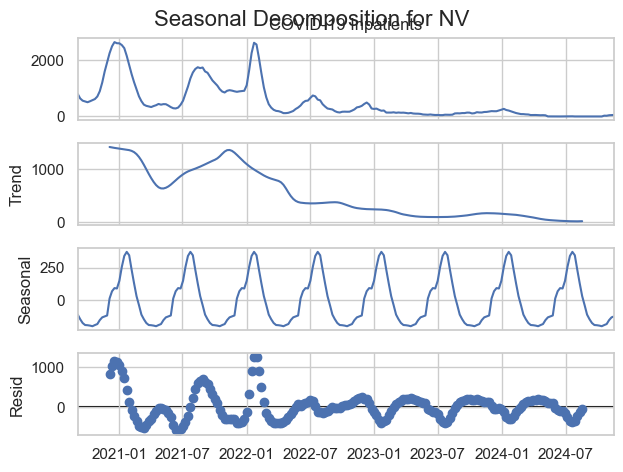

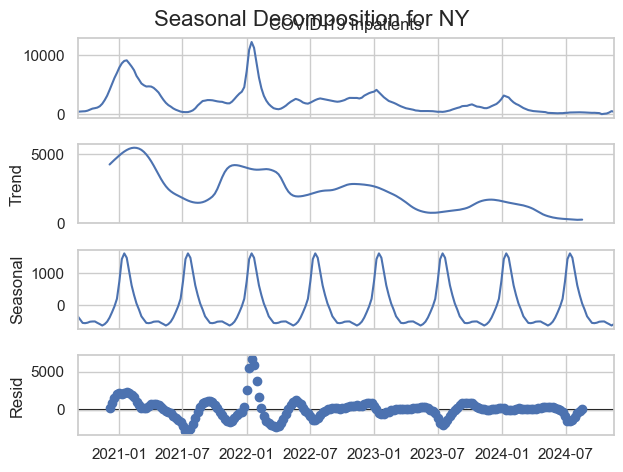

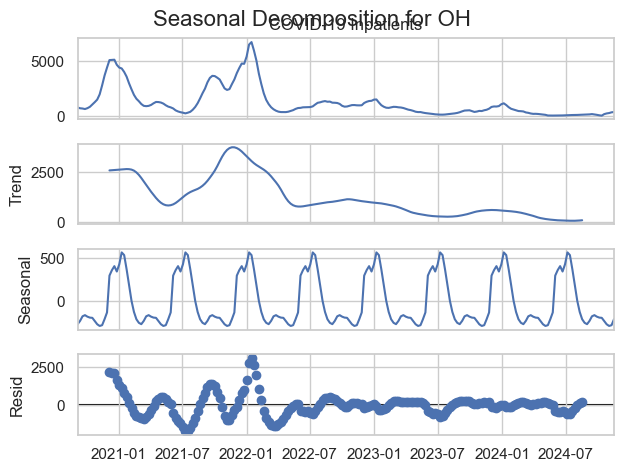

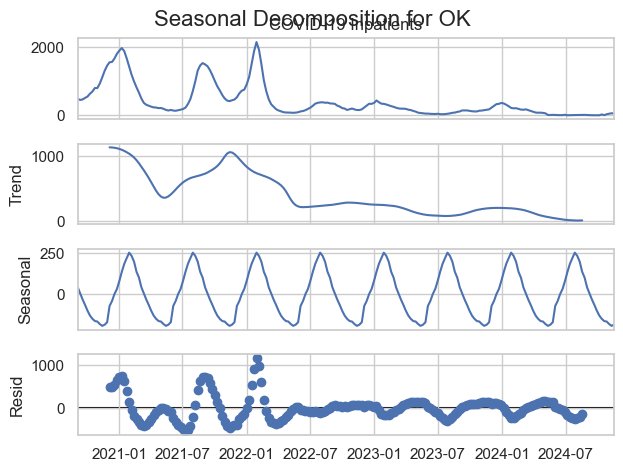

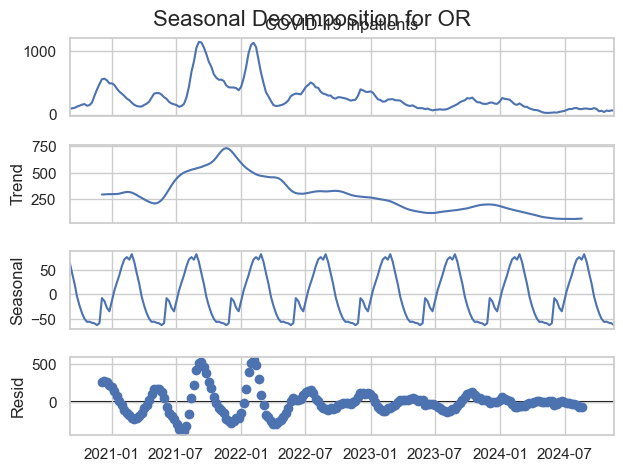

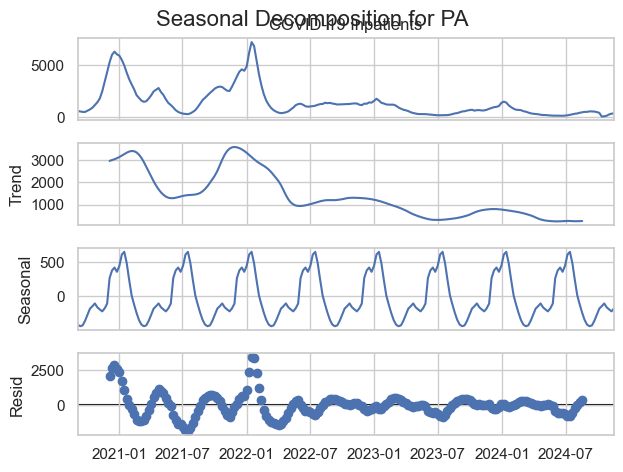

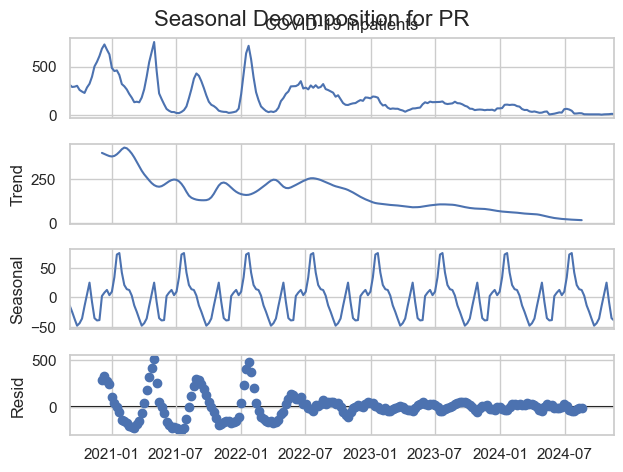

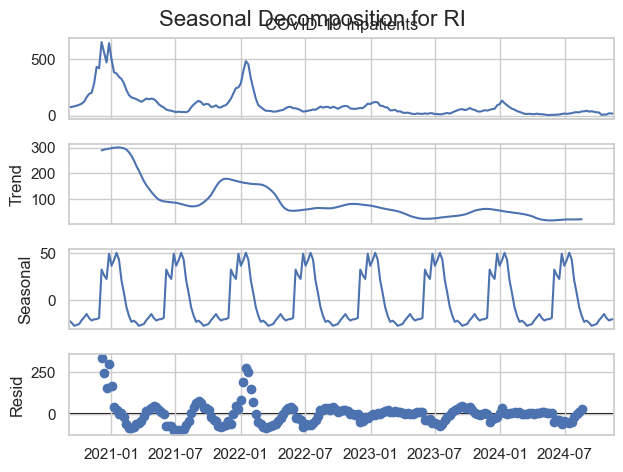

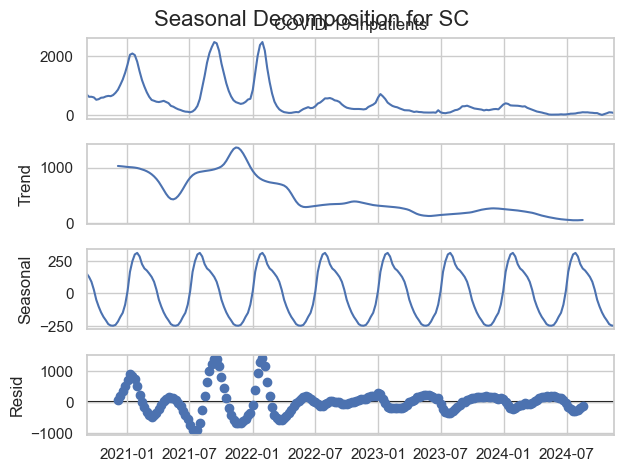

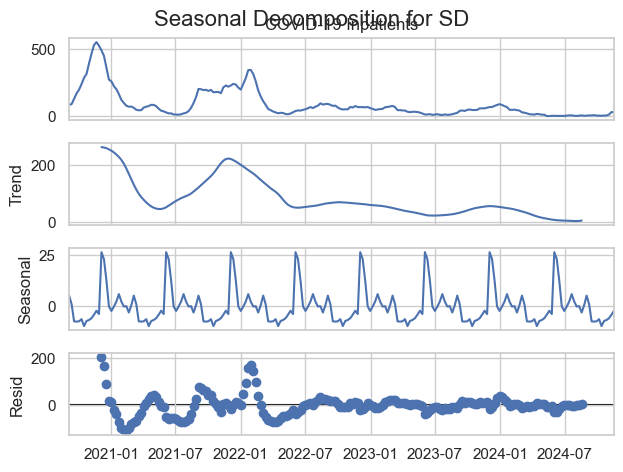

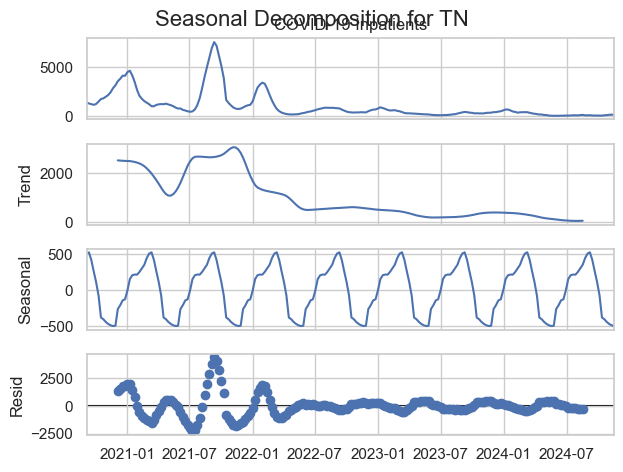

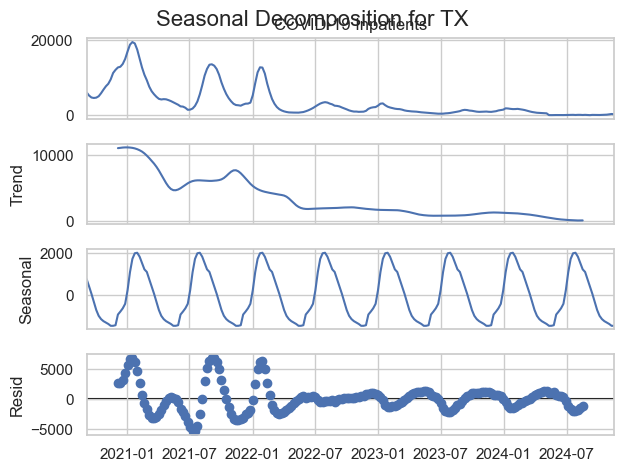

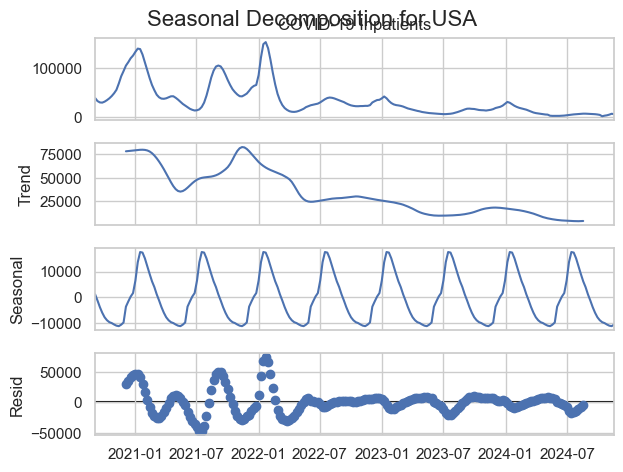

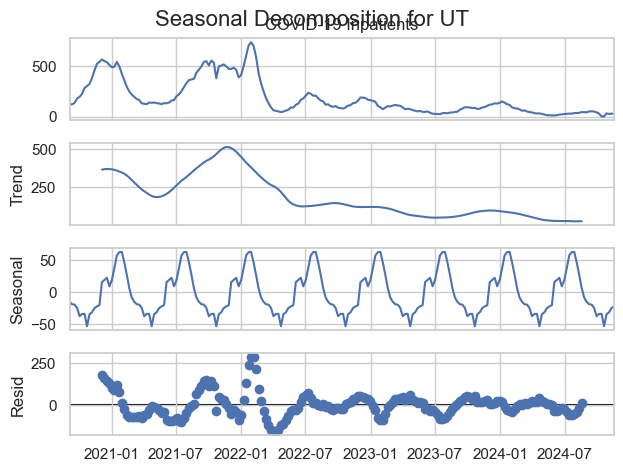

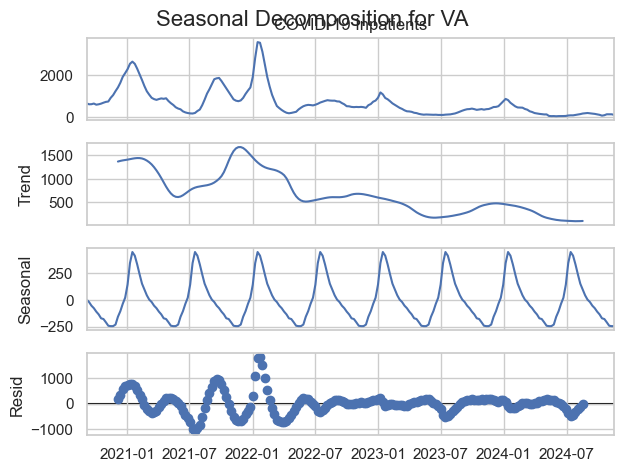

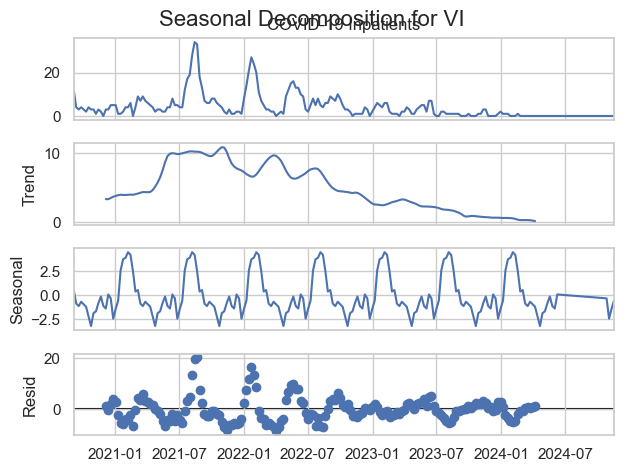

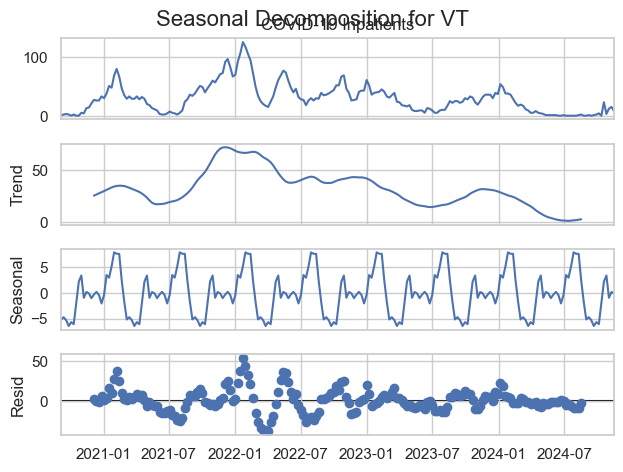

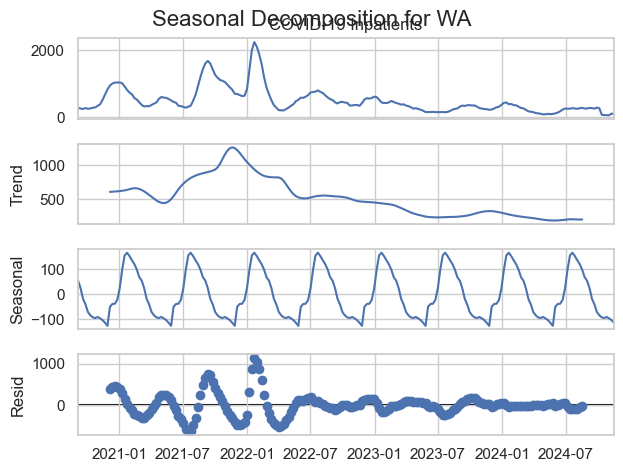

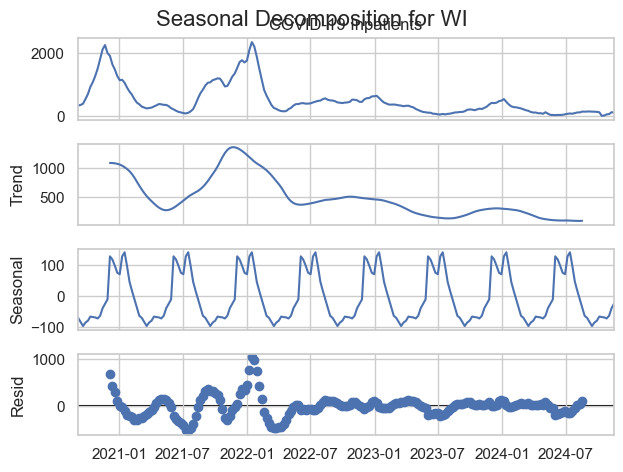

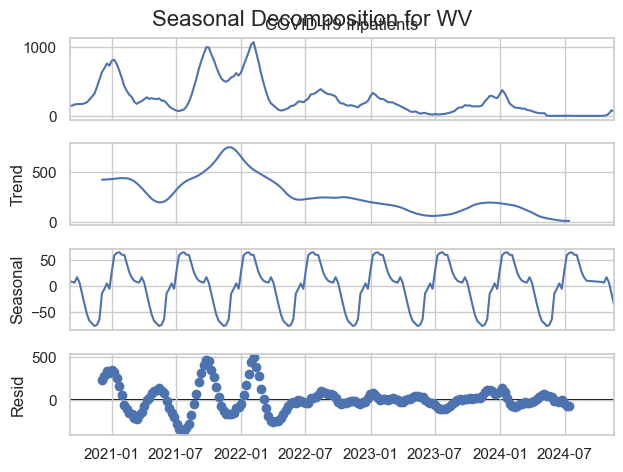

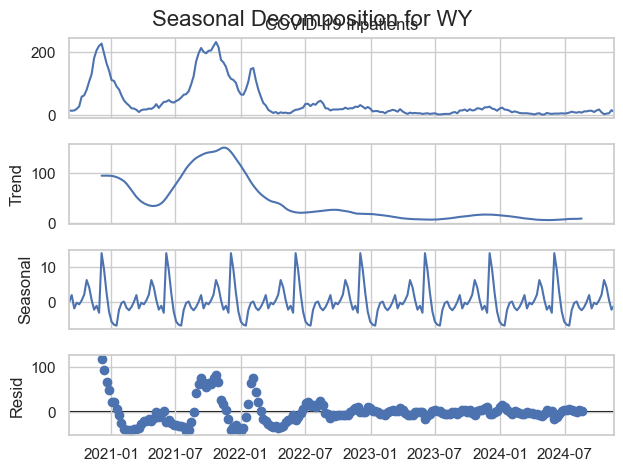

In [19]:
# Decompose Time Series
from statsmodels.tsa.seasonal import seasonal_decompose

for region in regions:
    ts = df_model[df_model['Geographic aggregation'] == region]['COVID-19 Inpatients']
    decomposition = seasonal_decompose(ts, model='additive', period=26)  # Adjust 'period' based on seasonality (e.g., weekly data with yearly seasonality)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition for {region}', fontsize=16)
    plt.show()

ADF Statistic for AK: -3.205189322155792
p-value: 0.01968625902544304


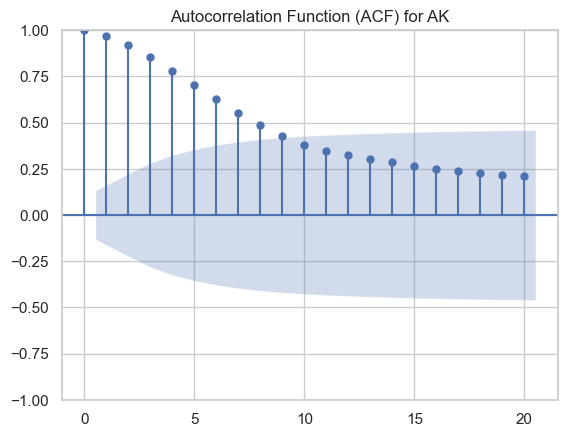

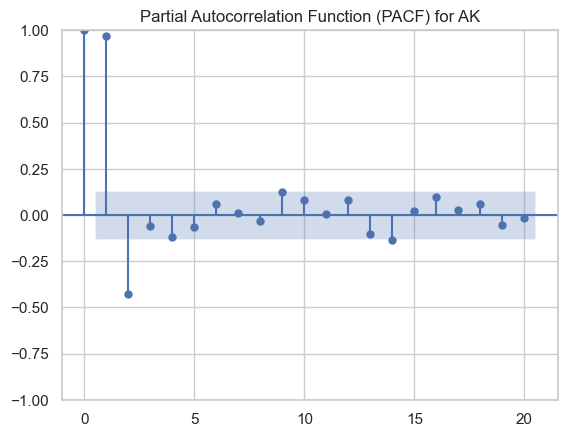

ADF Statistic for AL: -2.197794676310983
p-value: 0.20704683560554432


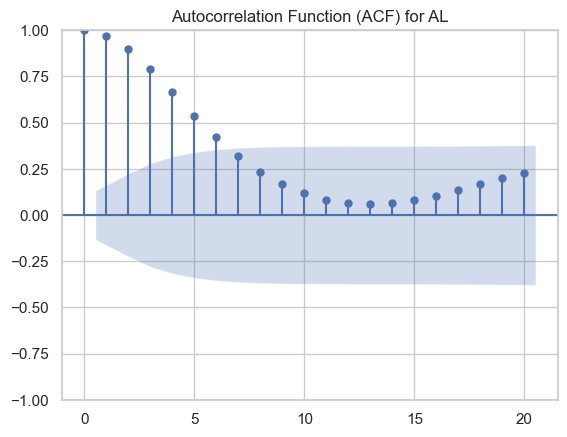

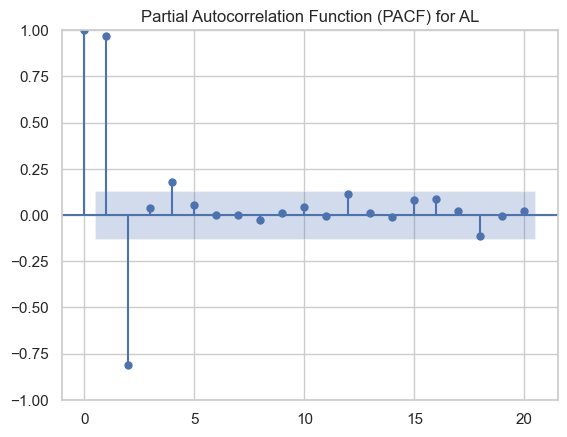

ADF Statistic for AR: -3.0540424169617473
p-value: 0.03014654117882209


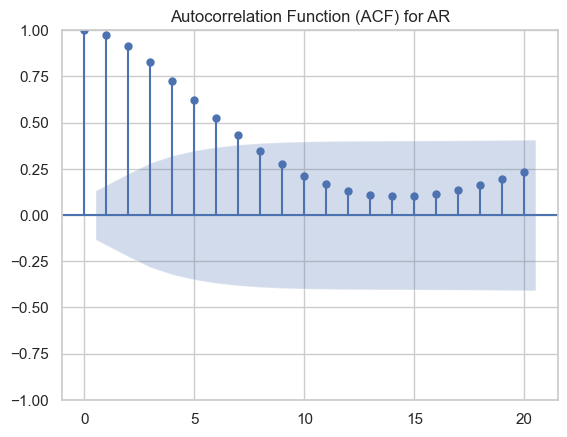

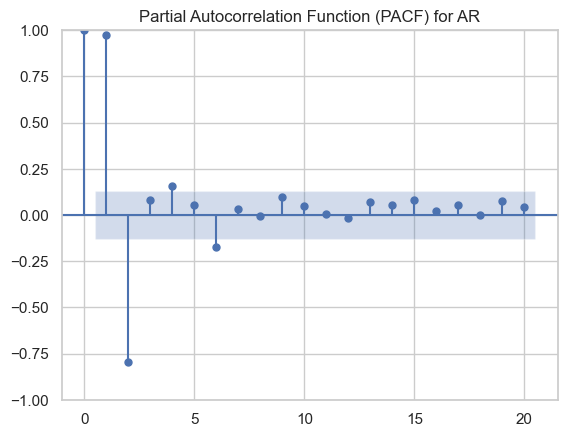

ADF Statistic for AS: -4.809336206341049
p-value: 5.219296663168914e-05


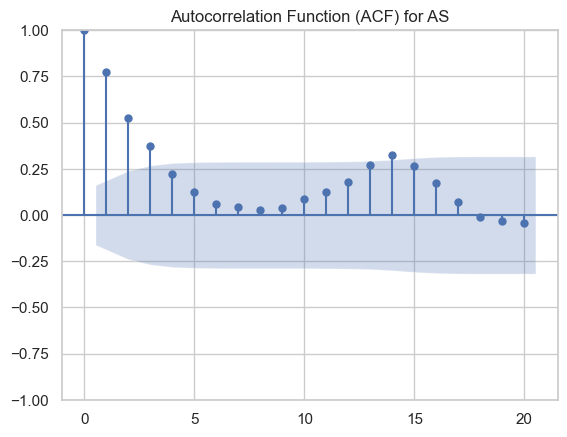

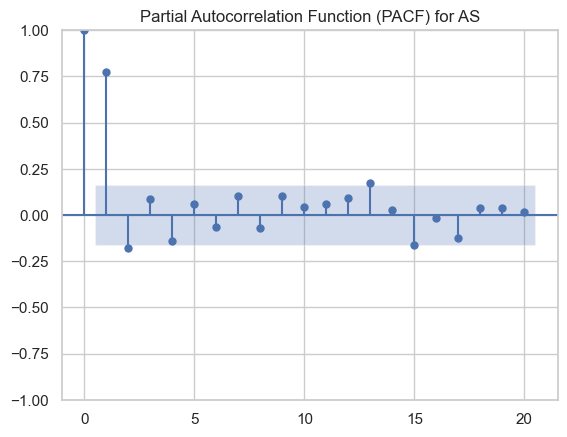

ADF Statistic for AZ: -3.399006112380863
p-value: 0.010992799865614612


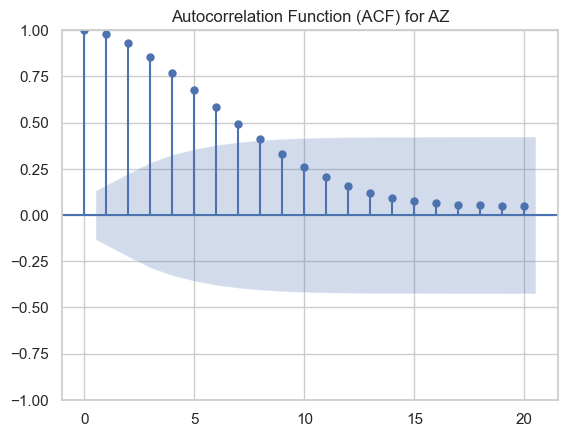

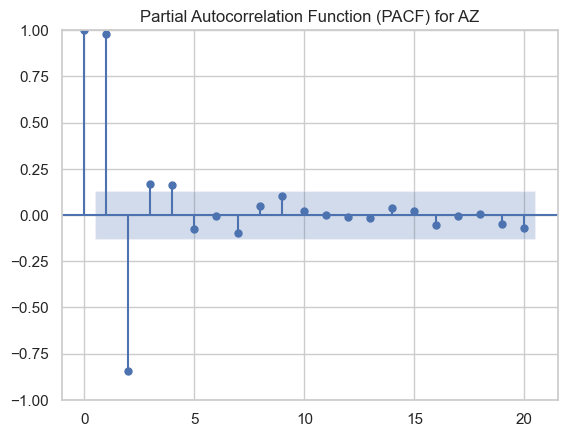

ADF Statistic for CA: -3.1504392537280665
p-value: 0.023038732829200912


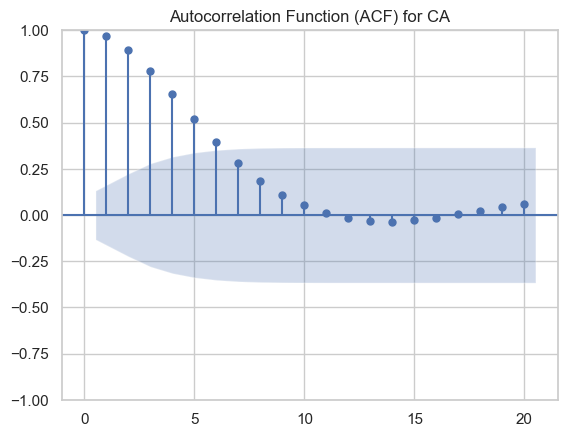

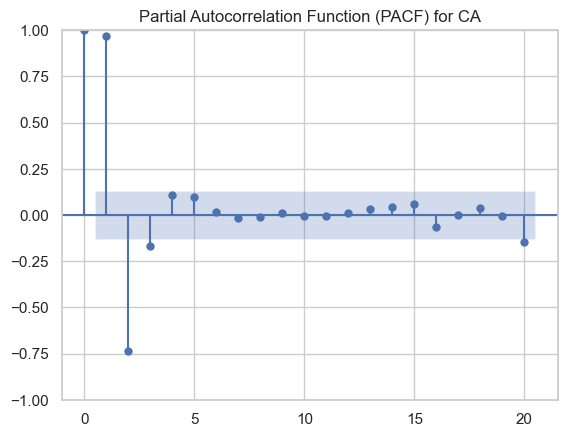

ADF Statistic for CO: -2.857035349695361
p-value: 0.050577182479629286


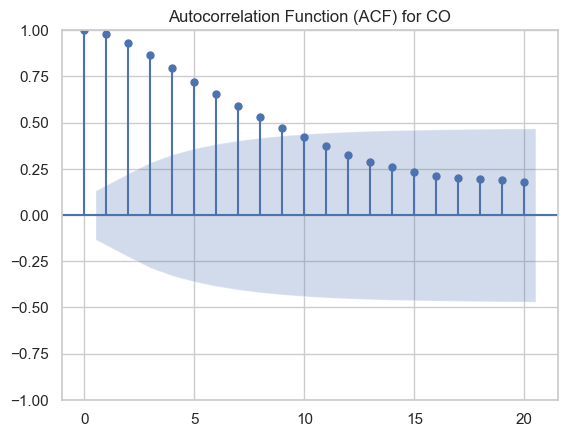

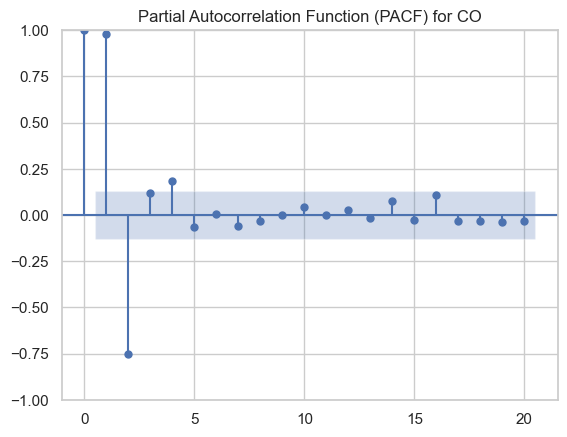

ADF Statistic for CT: -3.996737354613933
p-value: 0.0014276921077766114


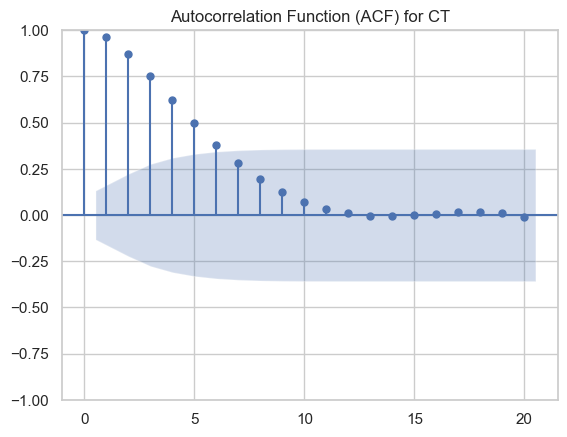

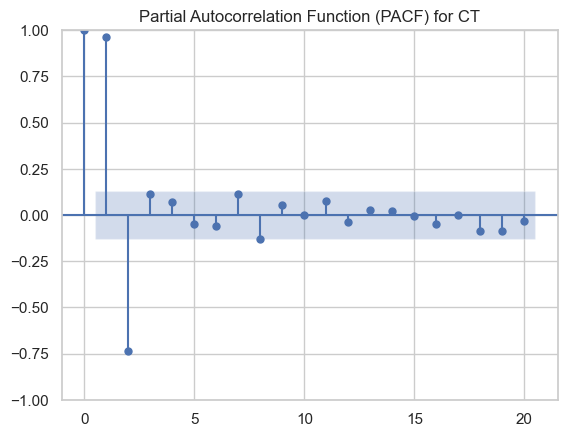

ADF Statistic for DC: -4.029579550483013
p-value: 0.0012633029977051292


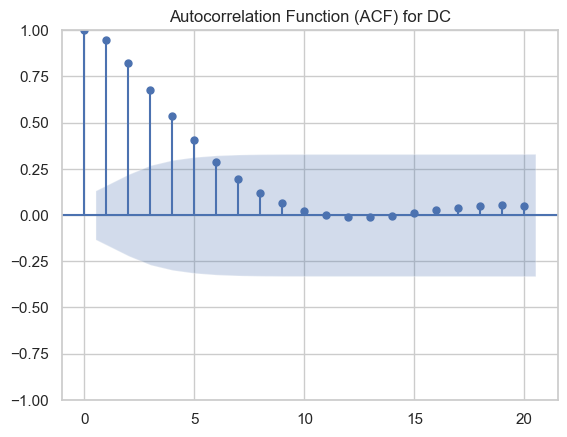

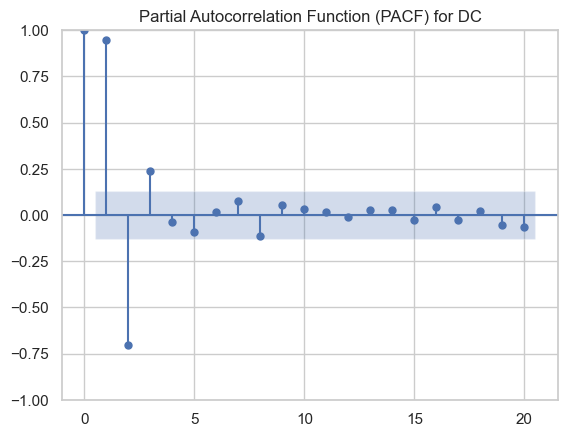

ADF Statistic for DE: -3.9582090982552676
p-value: 0.0016458635443421619


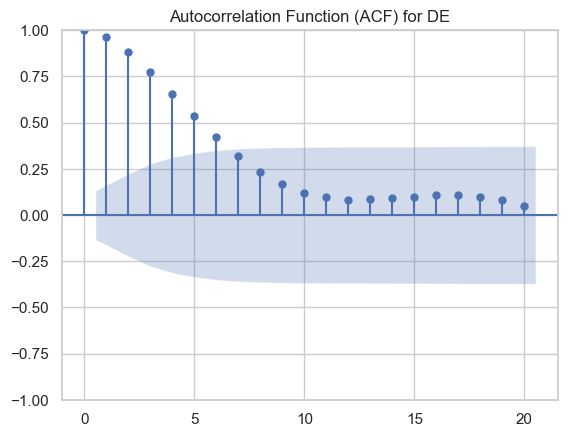

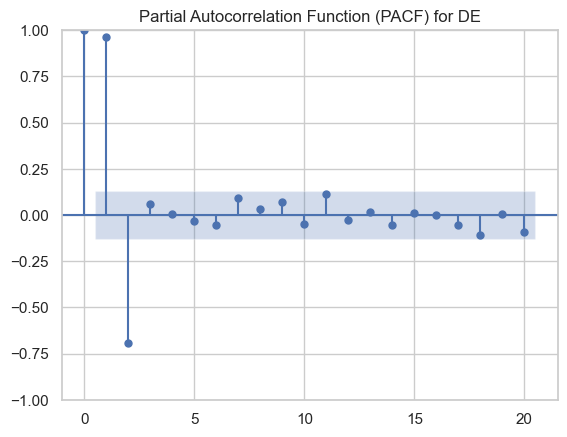

ADF Statistic for FL: -4.101278654303546
p-value: 0.0009638218280514336


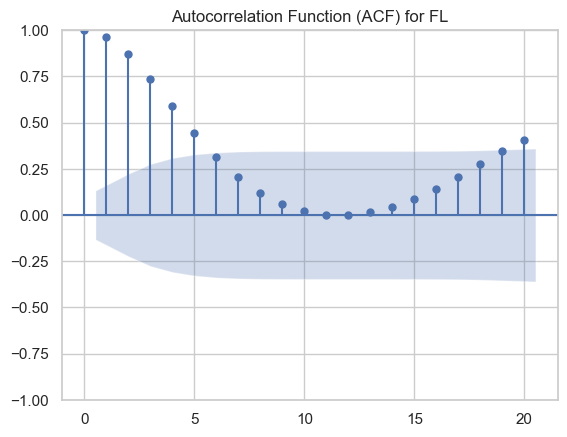

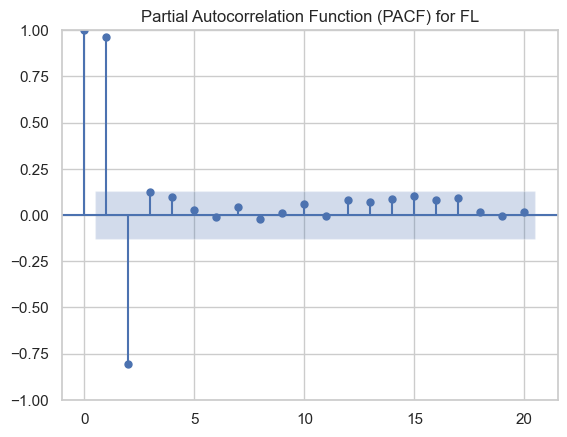

ADF Statistic for GA: -3.5272762571648344
p-value: 0.007313599777977471


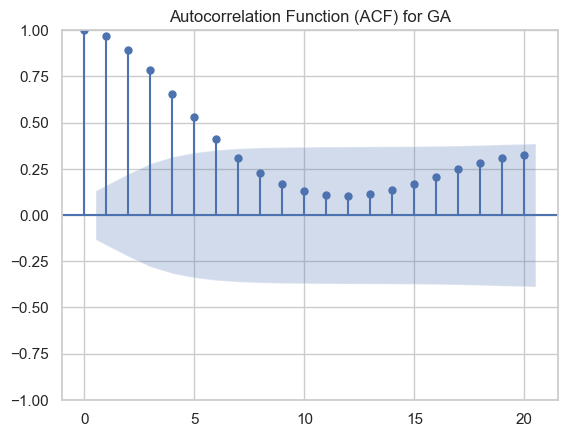

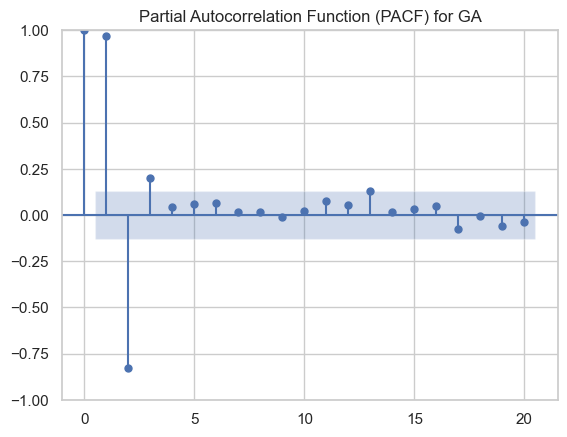

ADF Statistic for GU: -3.8100730317519145
p-value: 0.0028059198601848743


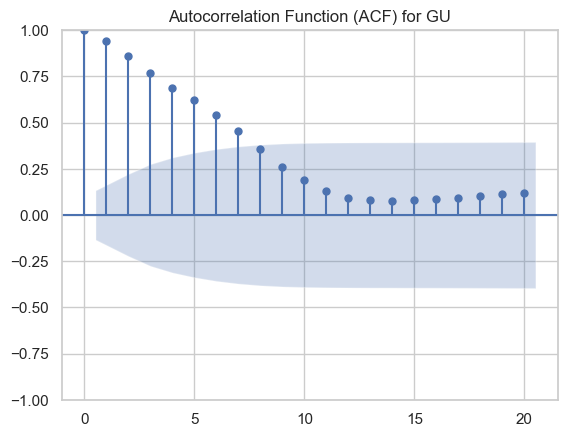

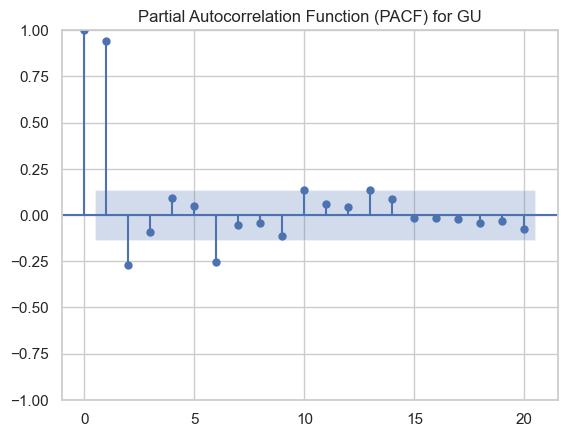

ADF Statistic for HI: -1.5999709457224705
p-value: 0.4836080646281722


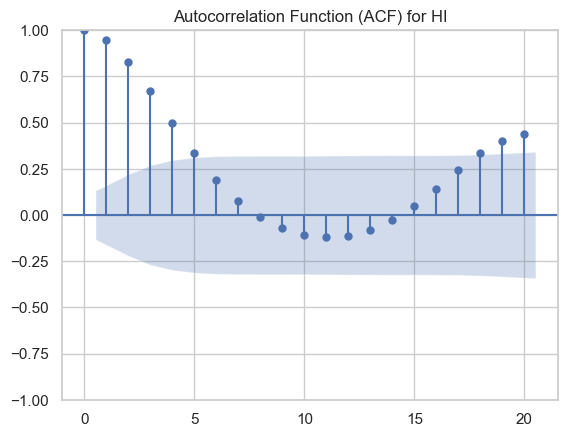

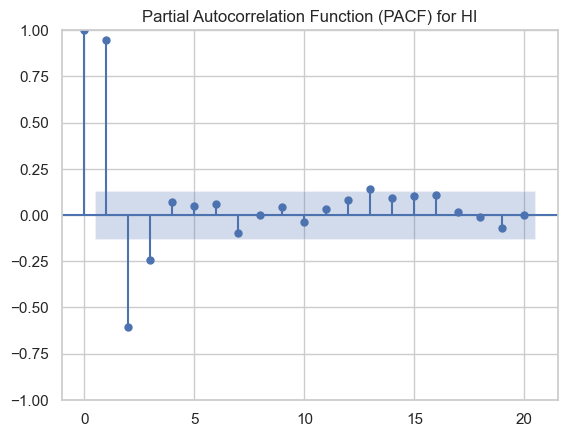

ADF Statistic for IA: -3.4398783269983886
p-value: 0.009672255441638472


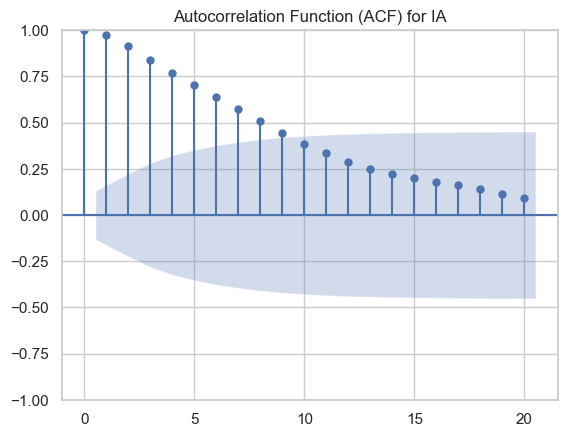

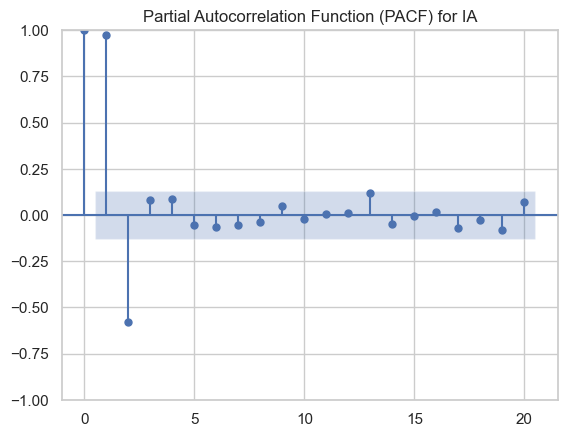

ADF Statistic for ID: -3.340526320724138
p-value: 0.013161320687047827


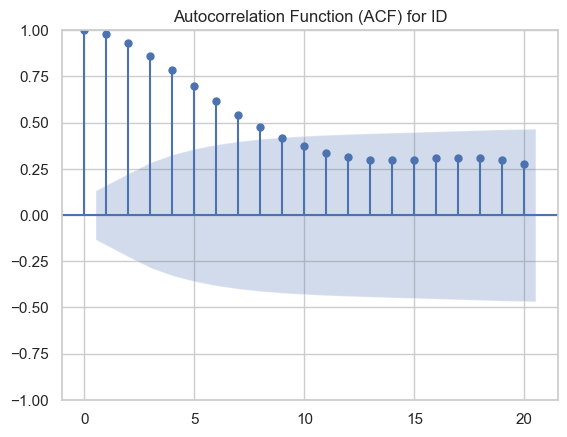

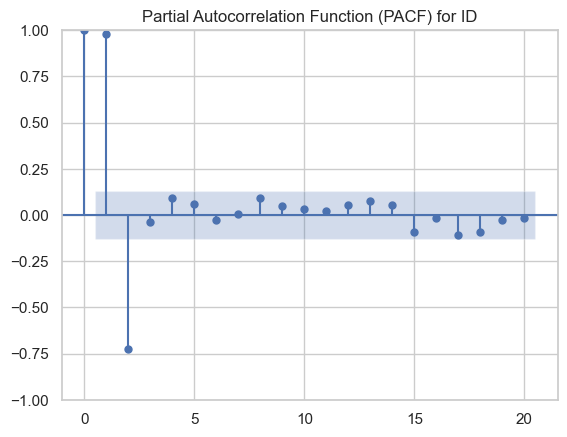

ADF Statistic for IL: -3.833181208068906
p-value: 0.0025855000082466266


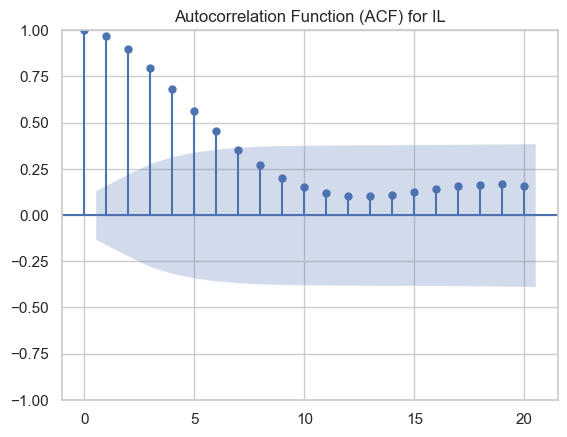

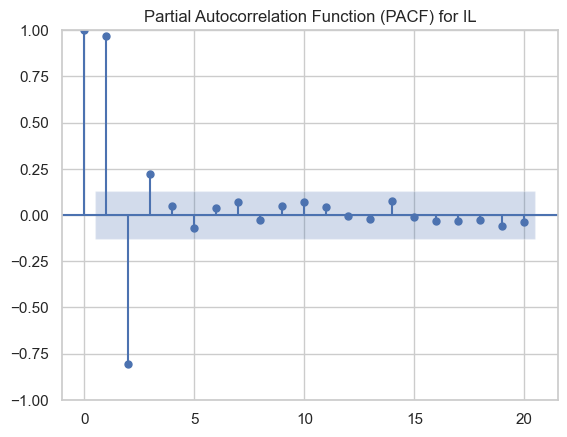

ADF Statistic for IN: -2.7693974894637594
p-value: 0.06277982882823861


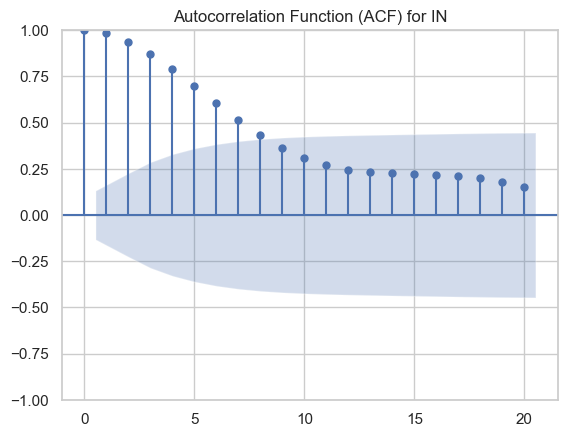

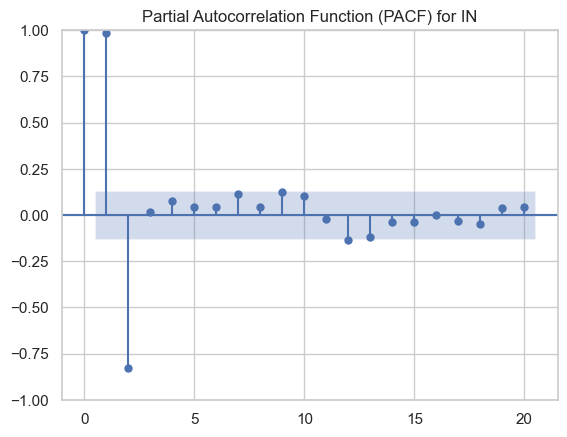

ADF Statistic for KS: -3.35874182930629
p-value: 0.012448390413221752


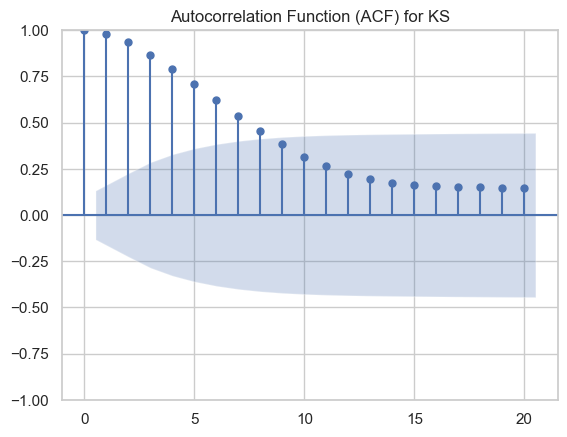

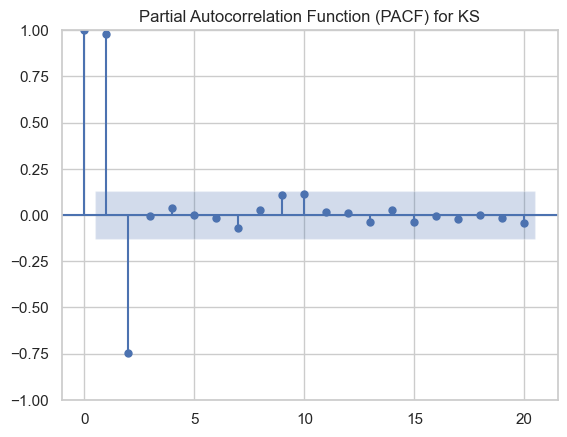

ADF Statistic for KY: -1.9753675945229594
p-value: 0.2974768754312458


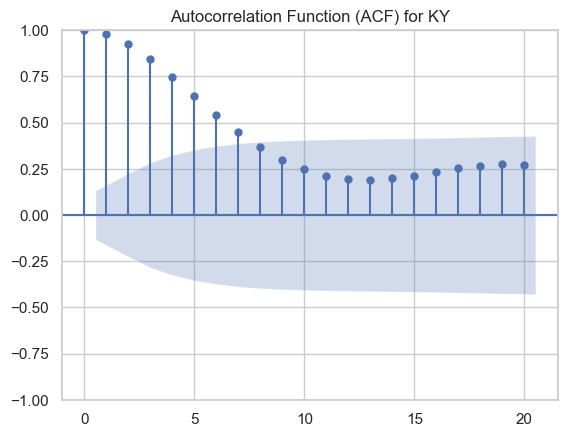

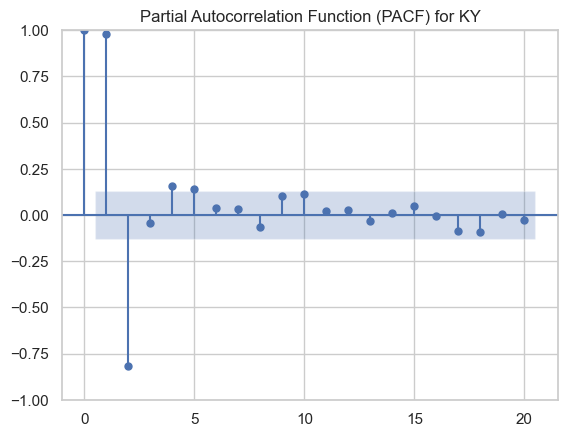

ADF Statistic for LA: -3.408557704204787
p-value: 0.01067057656876509


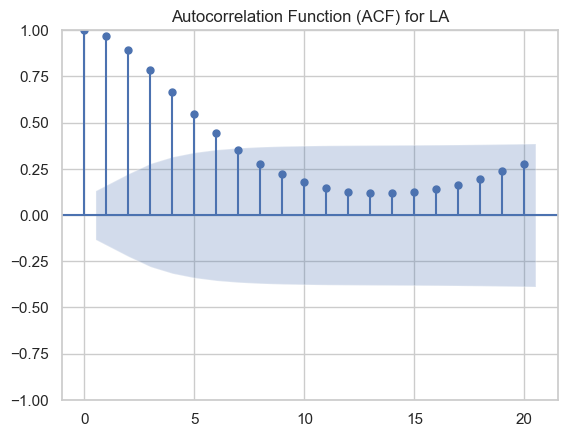

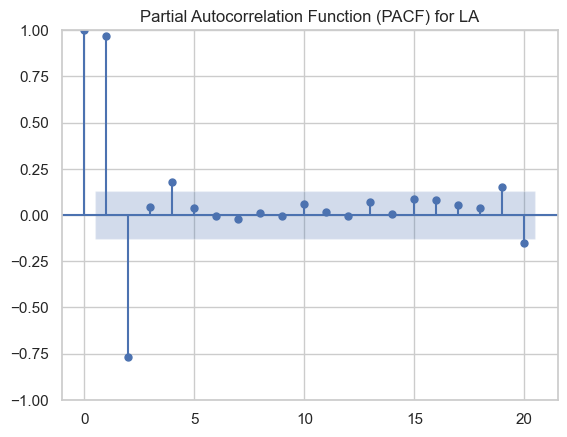

ADF Statistic for MA: -3.736790703128735
p-value: 0.0036244339095781205


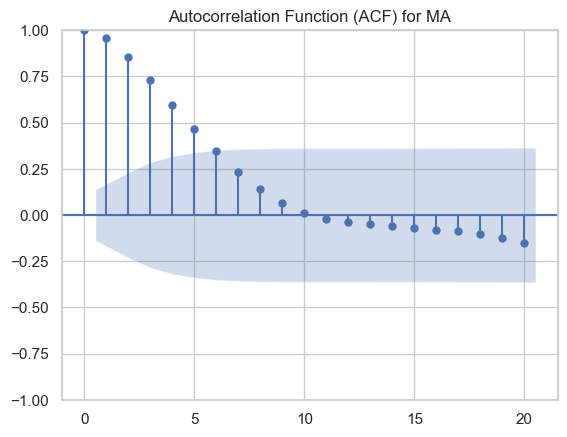

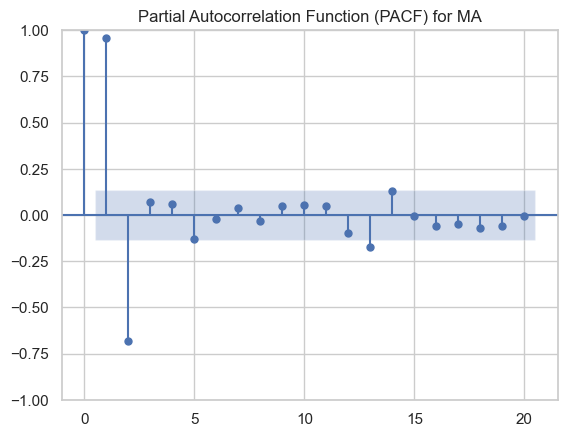

ADF Statistic for MD: -3.9039731737802117
p-value: 0.00200580053293245


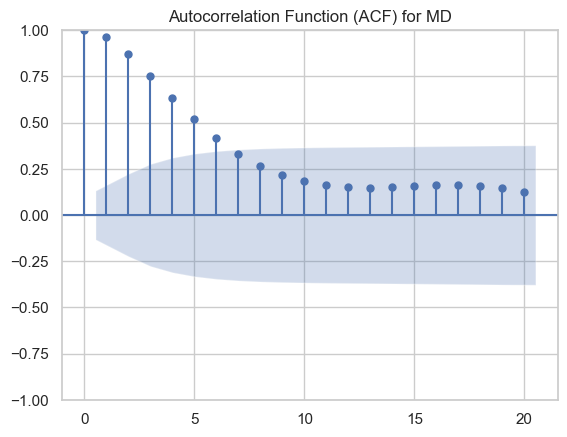

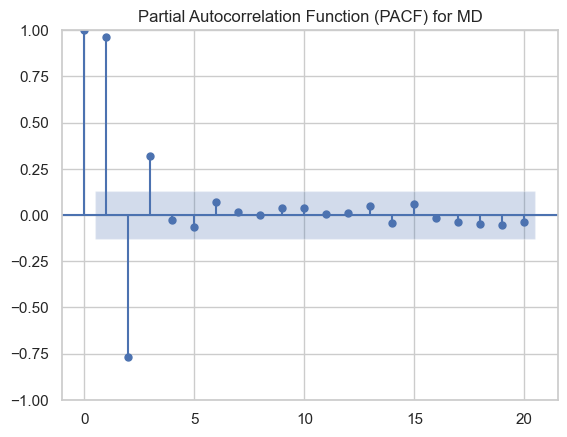

ADF Statistic for ME: -2.011403579097481
p-value: 0.28159551963096224


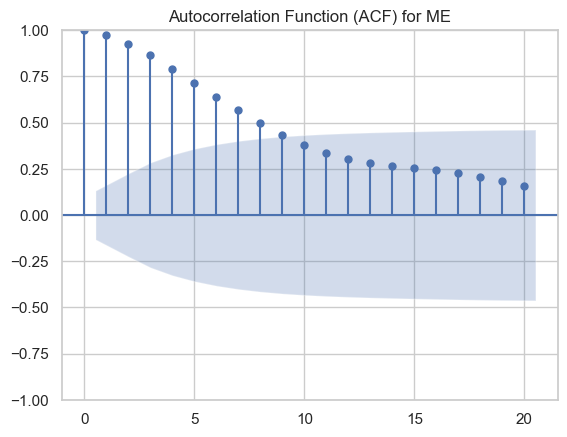

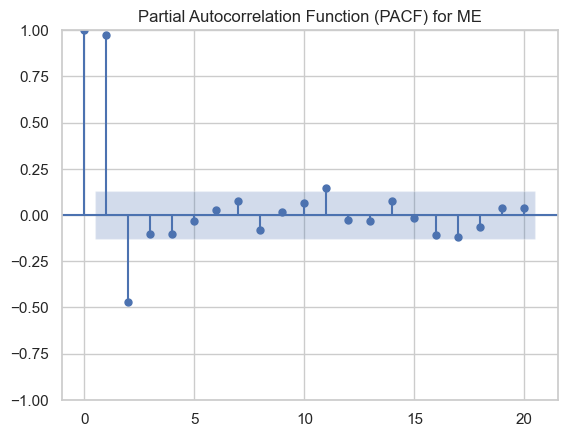

ADF Statistic for MI: -3.663243463382313
p-value: 0.004660899094497733


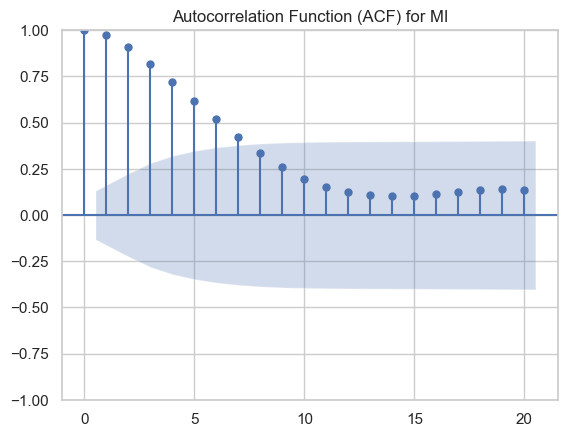

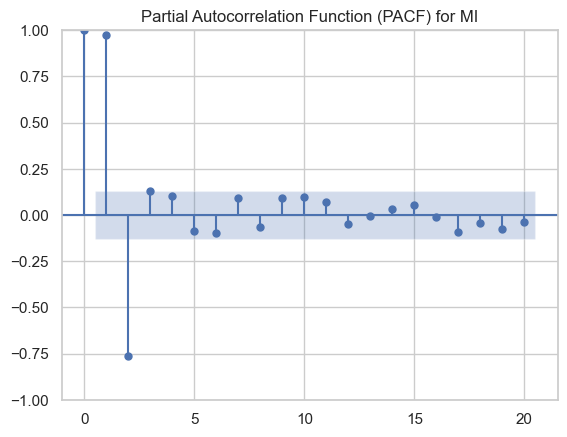

ADF Statistic for MN: -2.933339098944716
p-value: 0.04160620789545104


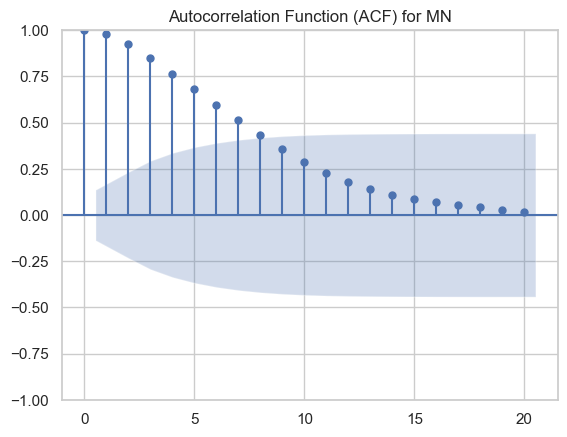

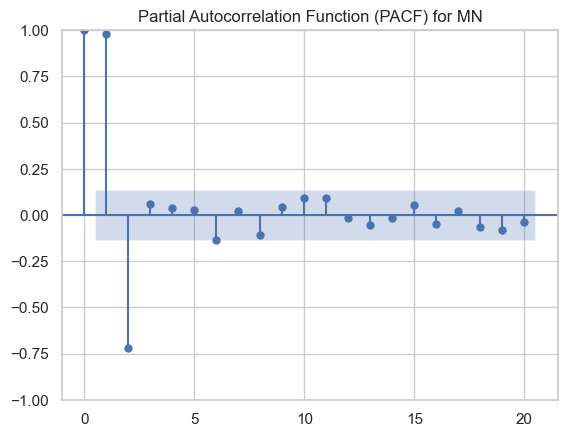

ADF Statistic for MO: -3.24372305797289
p-value: 0.017589270858596868


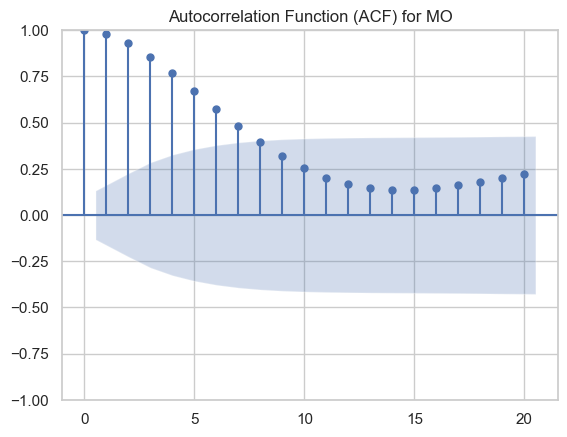

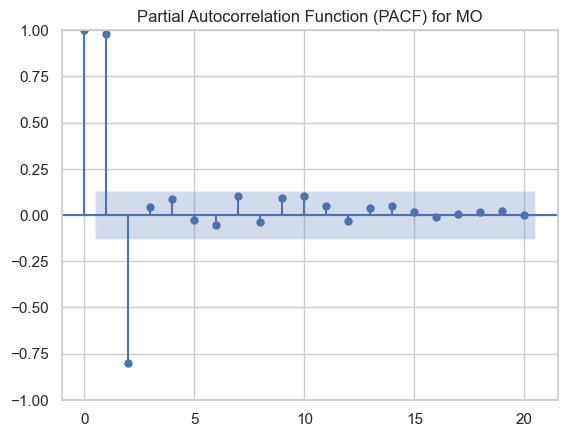

ADF Statistic for MP: -1.8797990407861842
p-value: 0.34162313118080345


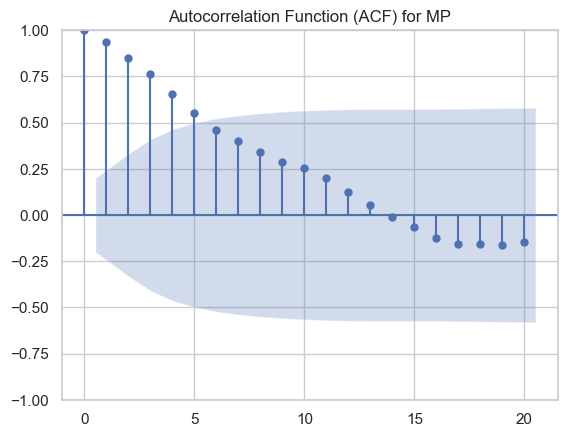

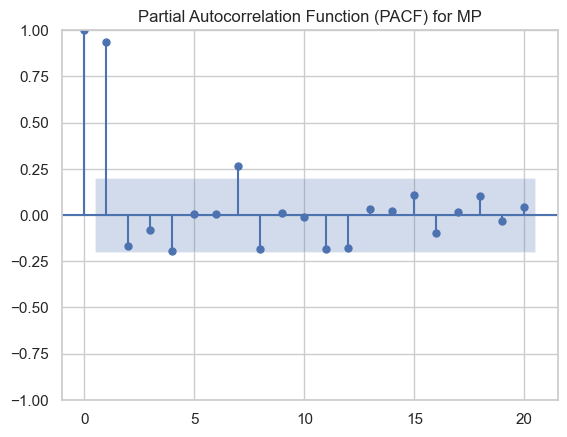

ADF Statistic for MS: -3.903554154928387
p-value: 0.0020088456252525706


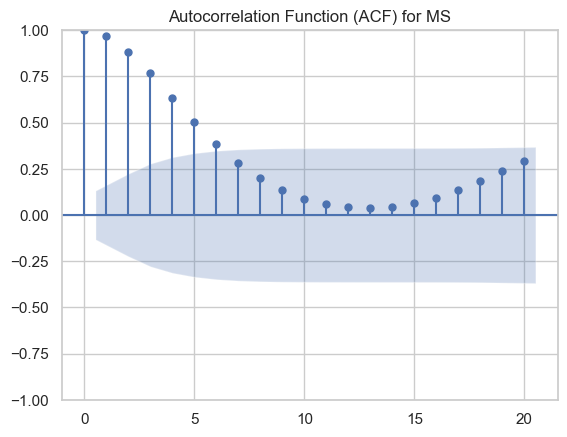

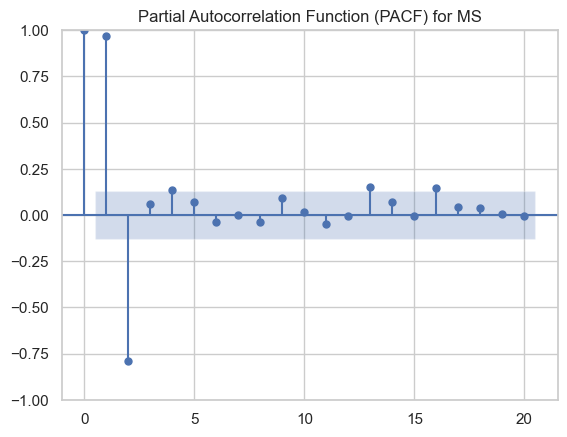

ADF Statistic for MT: -3.549120993698076
p-value: 0.00681162547510599


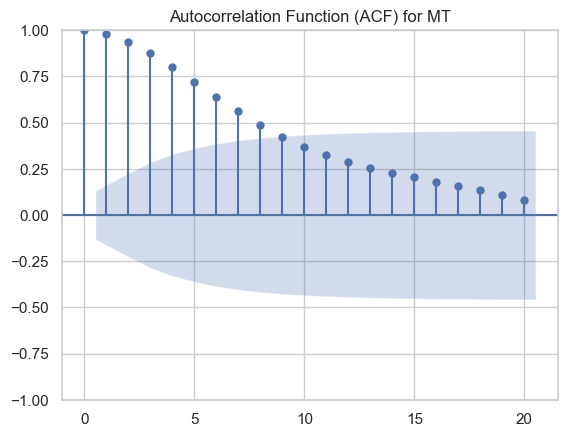

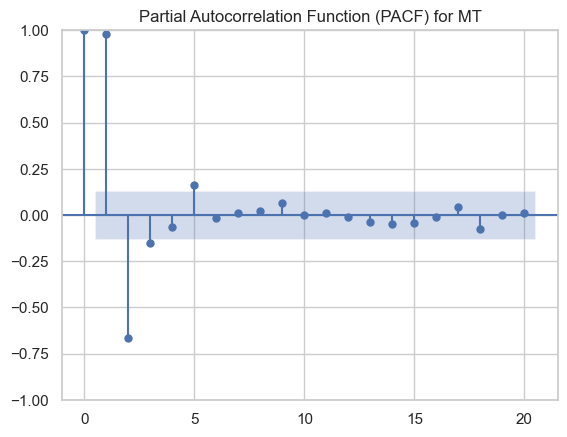

ADF Statistic for NC: -3.761313266729416
p-value: 0.003328880014277482


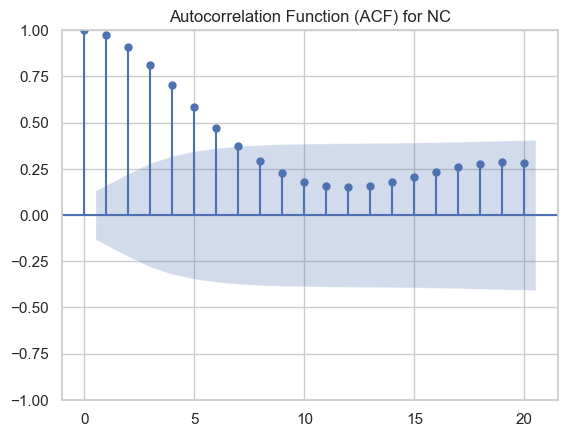

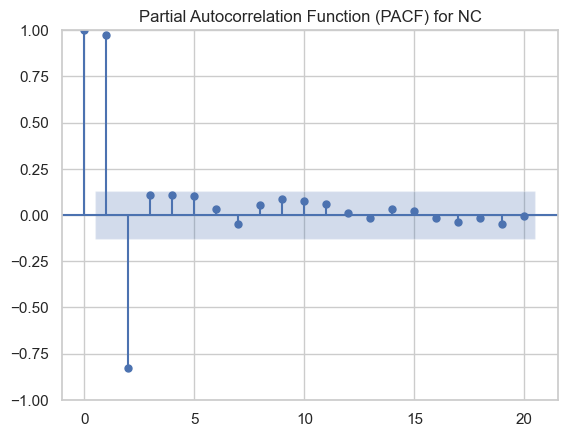

ADF Statistic for ND: -2.3110470626217388
p-value: 0.16842982408554968


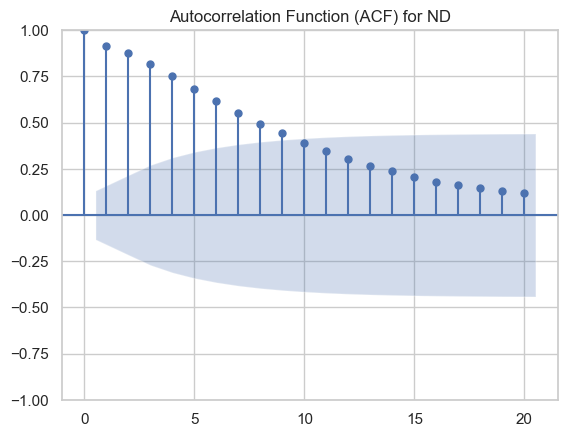

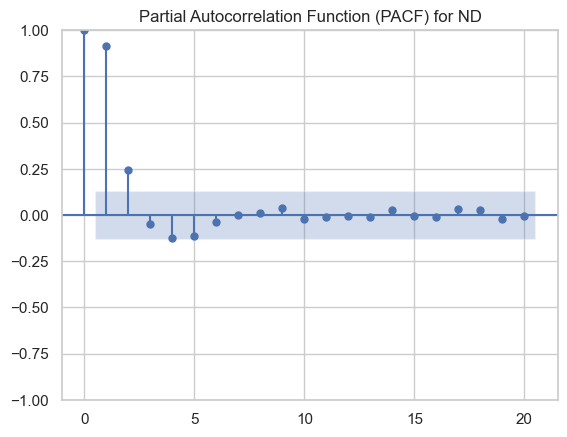

ADF Statistic for NE: -3.1140333152725344
p-value: 0.02553194110021688


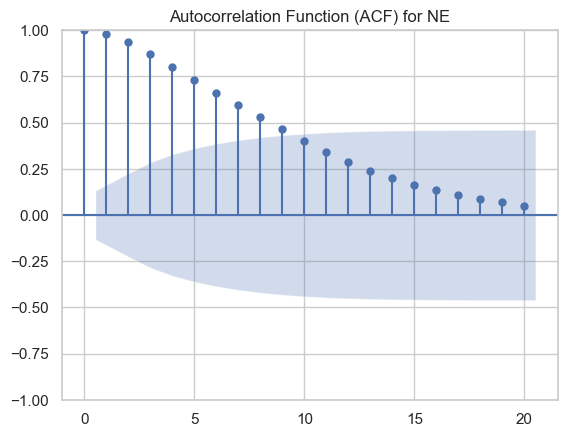

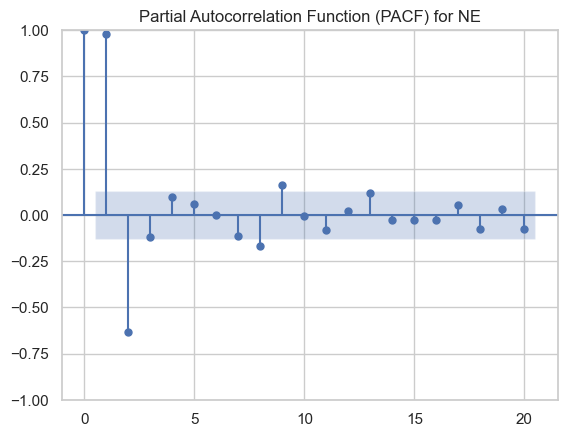

ADF Statistic for NH: -3.4035164090316954
p-value: 0.010839579976273843


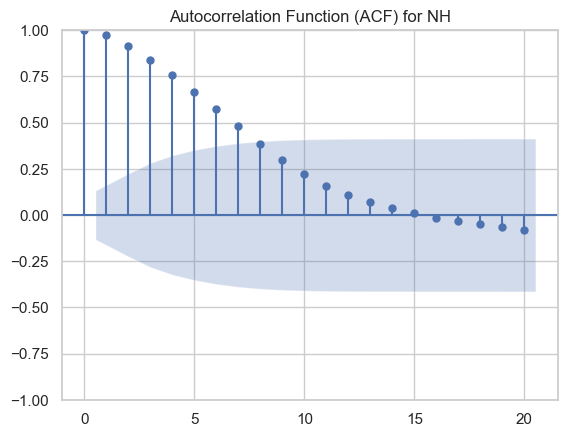

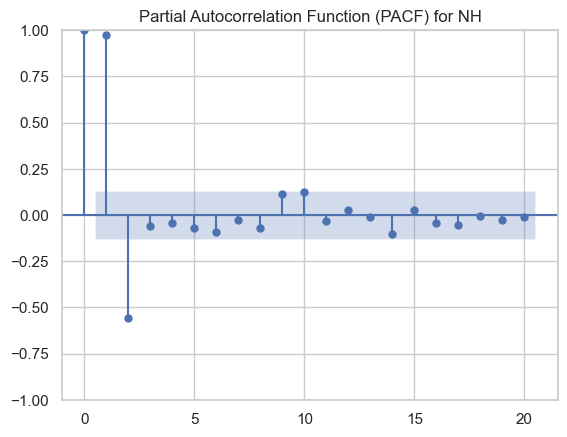

ADF Statistic for NJ: -3.9412196413297274
p-value: 0.0017515881492515199


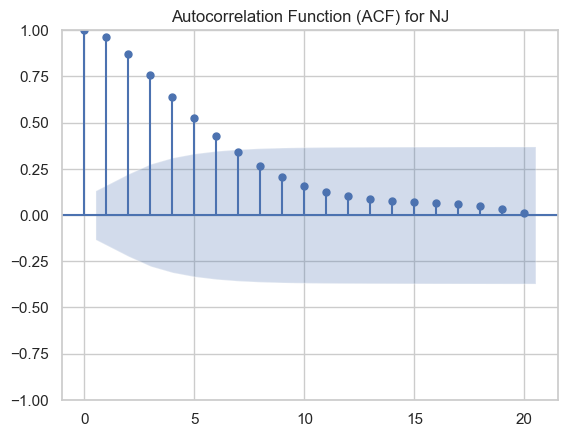

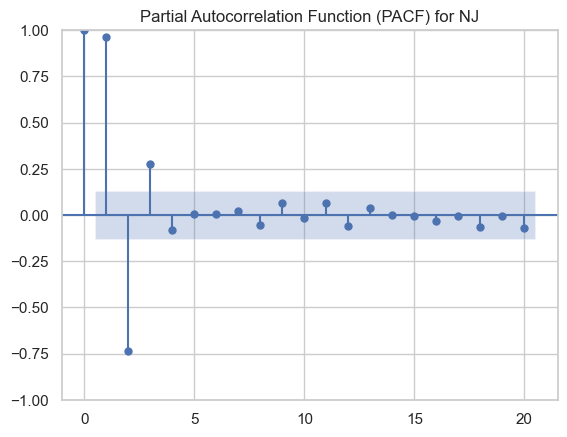

ADF Statistic for NM: -3.404496227253514
p-value: 0.010806547164471759


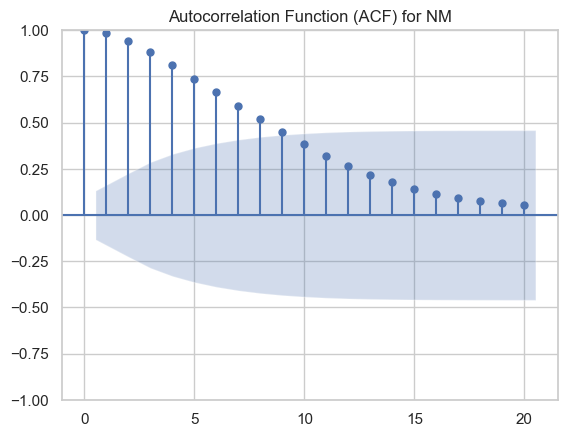

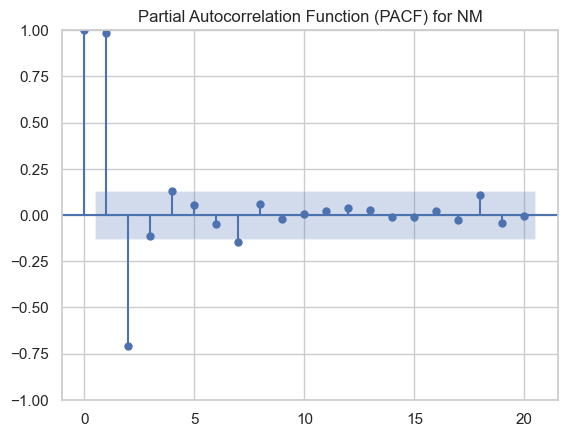

ADF Statistic for NV: -3.161340533163585
p-value: 0.022334360268593353


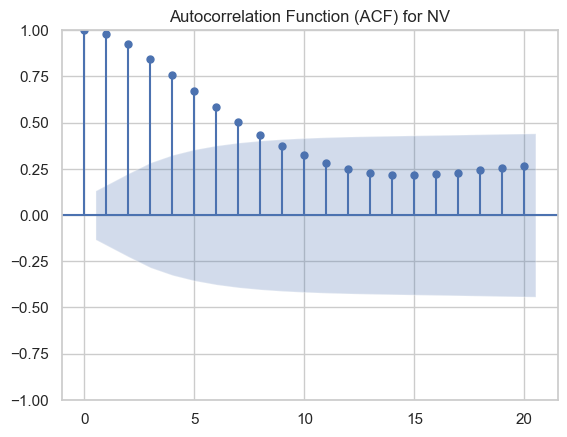

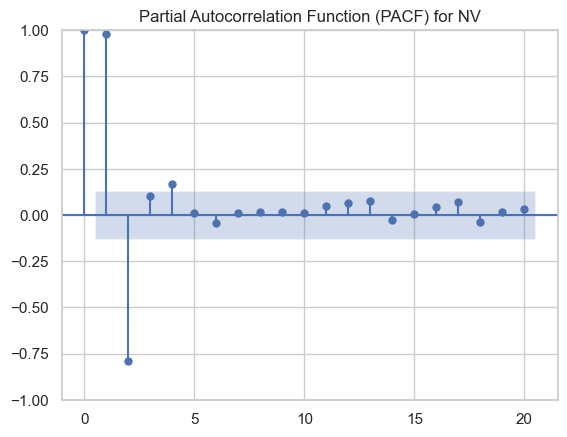

ADF Statistic for NY: -3.726982248024574
p-value: 0.0037492407439015042


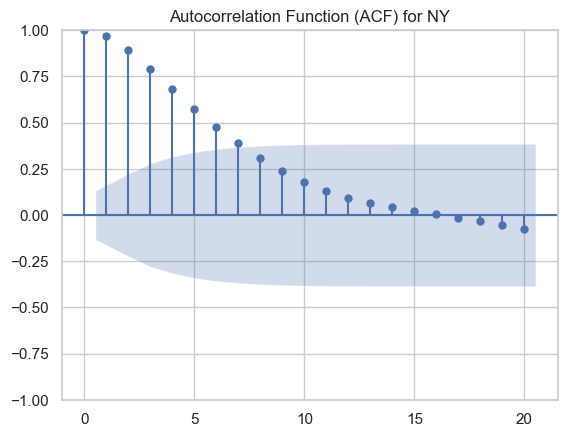

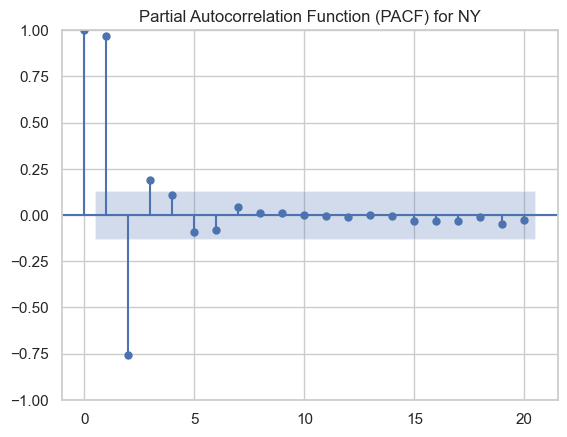

ADF Statistic for OH: -3.4765047897773504
p-value: 0.008611405892931124


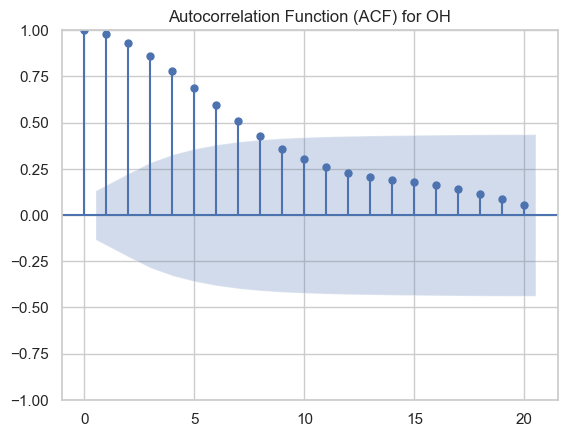

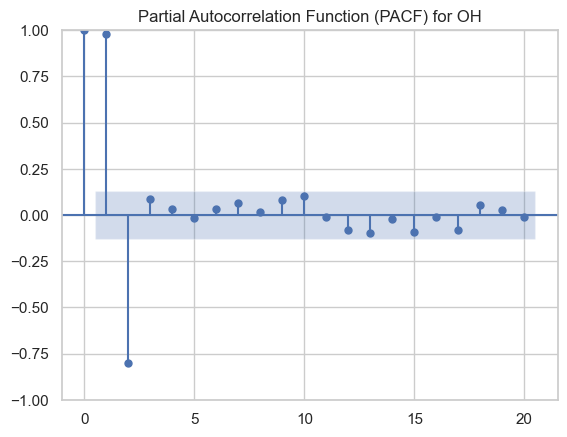

ADF Statistic for OK: -3.5382469228906435
p-value: 0.007057476551233027


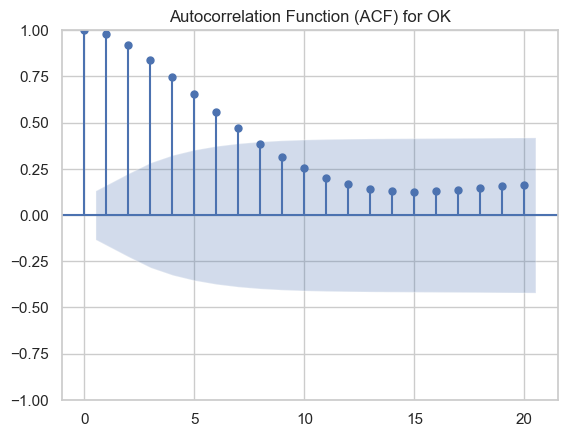

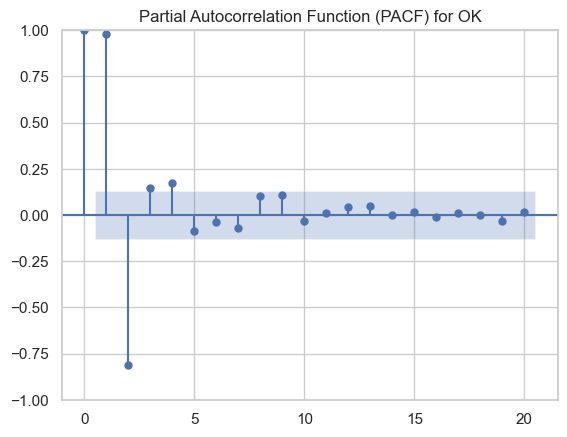

ADF Statistic for OR: -2.1102007579439706
p-value: 0.2404326582399141


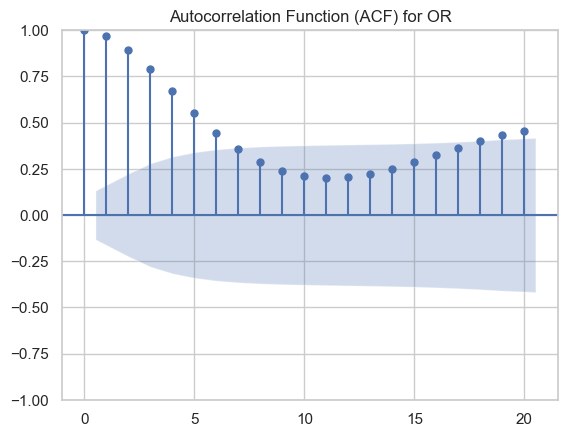

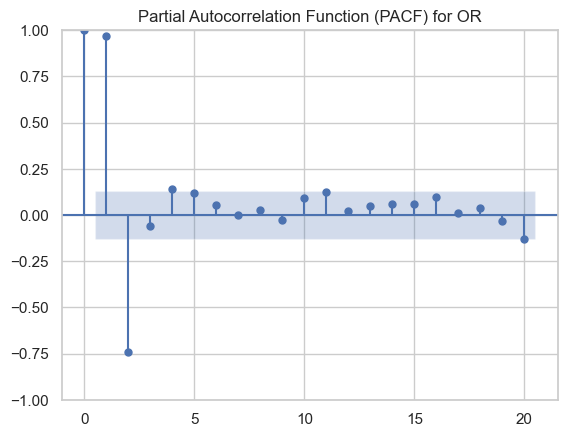

ADF Statistic for PA: -3.2311652439246377
p-value: 0.01825011607729535


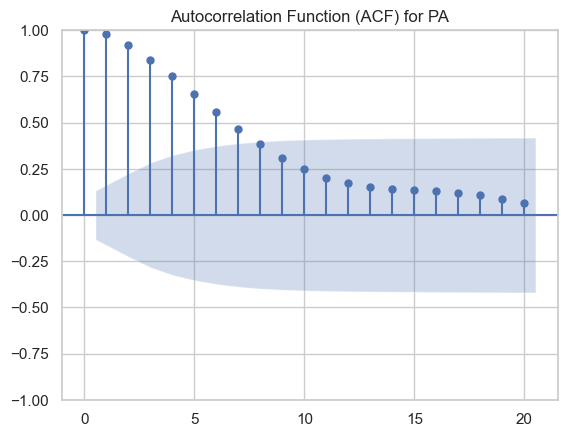

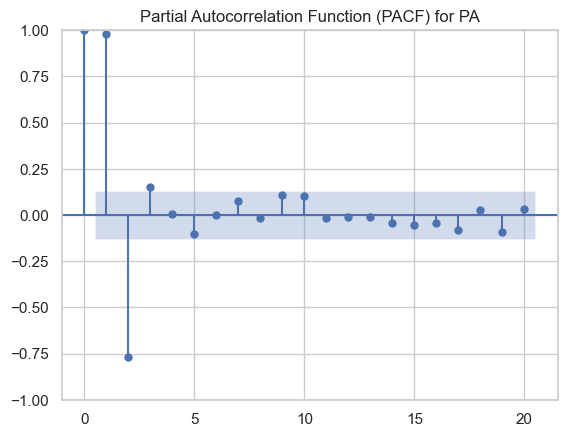

ADF Statistic for PR: -5.27097983781872
p-value: 6.2867231590385435e-06


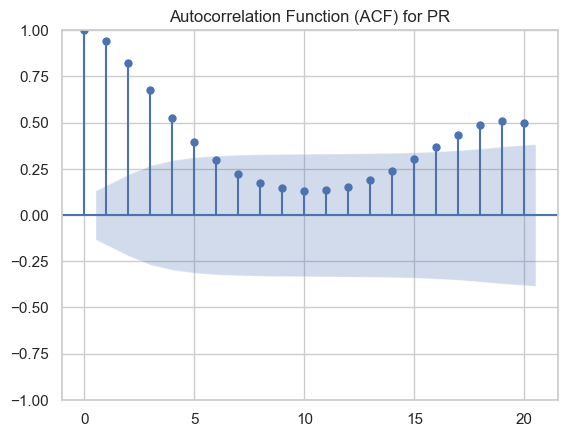

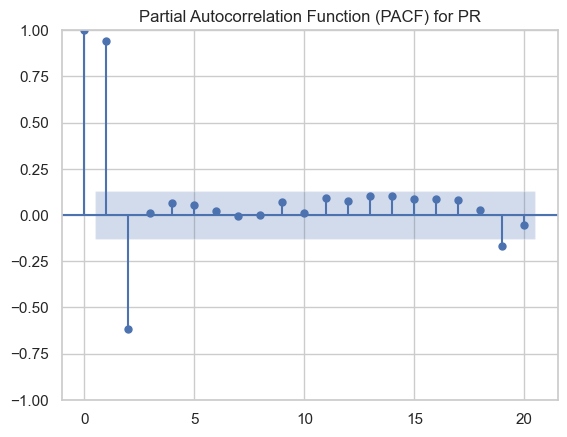

ADF Statistic for RI: -2.8448665052274946
p-value: 0.05214518742263985


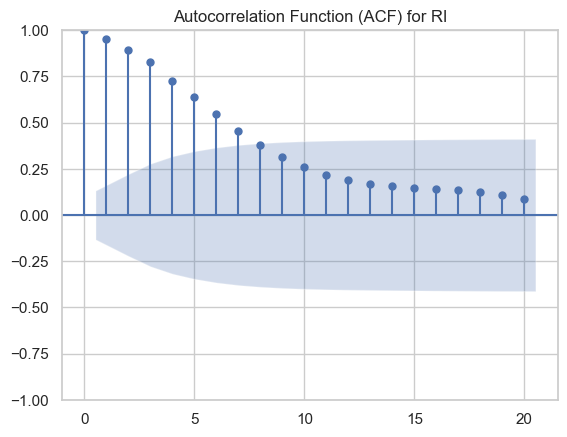

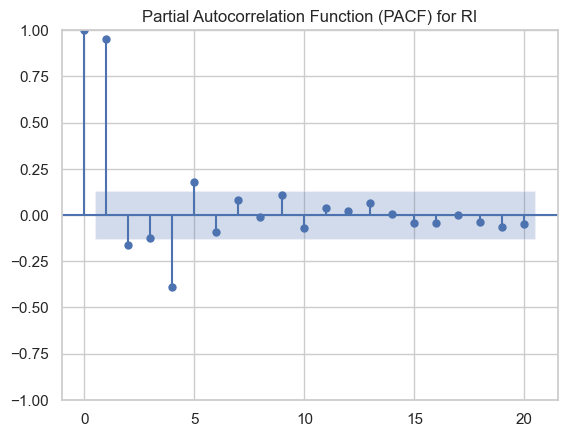

ADF Statistic for SC: -3.545930757898143
p-value: 0.006882938947717578


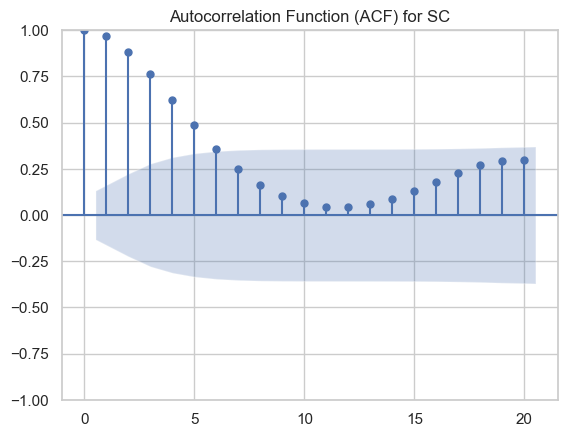

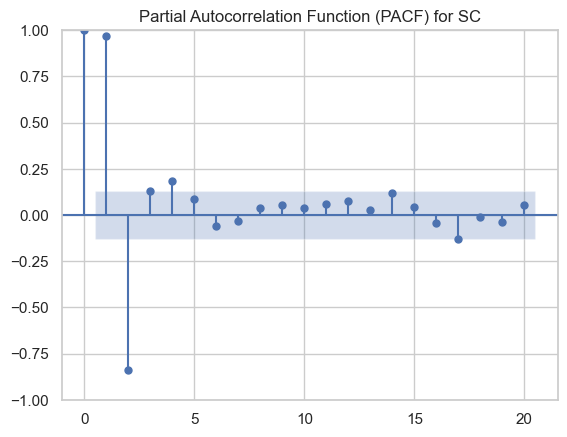

ADF Statistic for SD: -3.5435454170044483
p-value: 0.006936699899376664


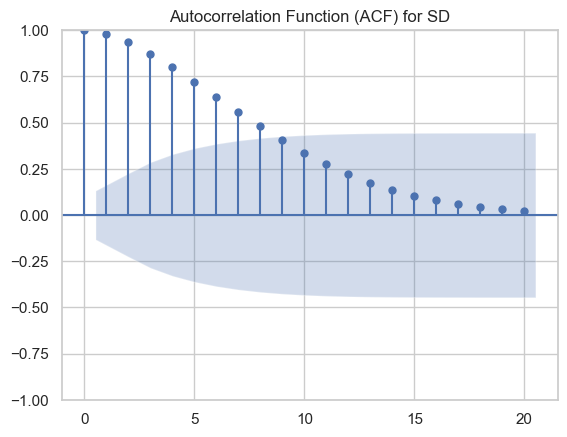

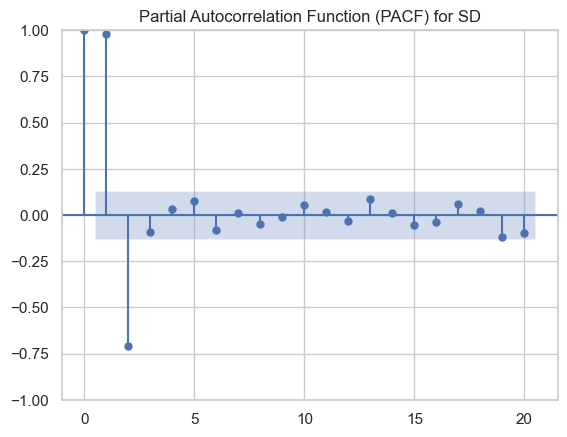

ADF Statistic for TN: -2.847540676262505
p-value: 0.051797237332218644


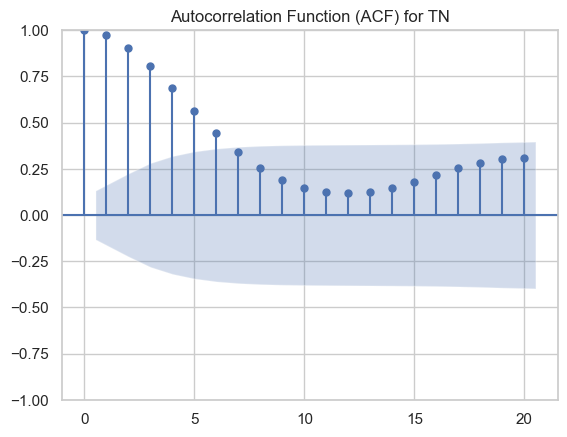

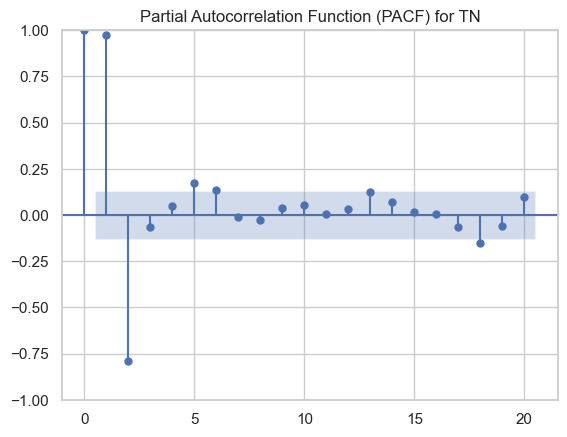

ADF Statistic for TX: -2.6144887064170557
p-value: 0.09003956785839401


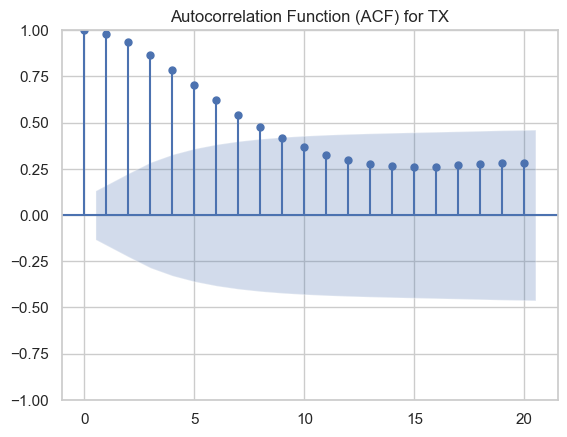

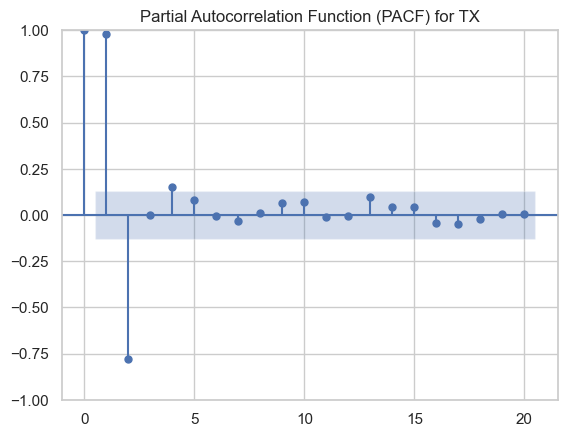

ADF Statistic for USA: -3.1197810963641426
p-value: 0.02512351273170748


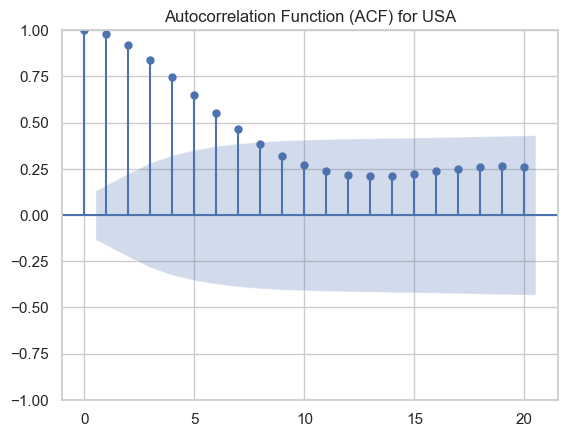

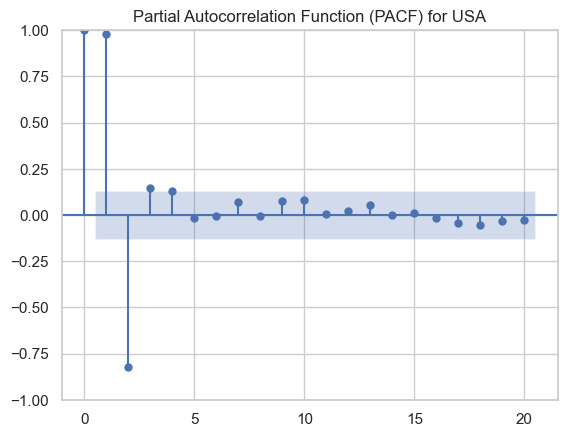

ADF Statistic for UT: -2.2949245500390885
p-value: 0.17361013073655818


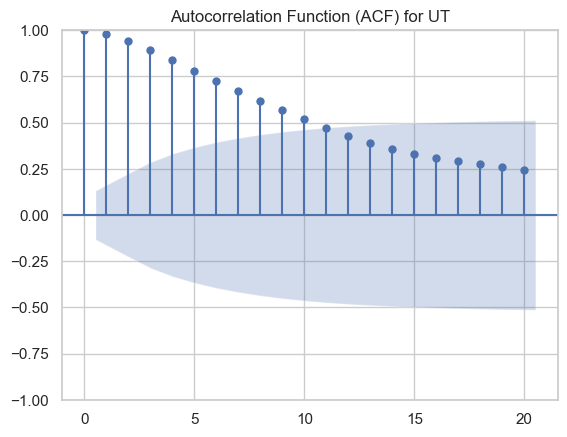

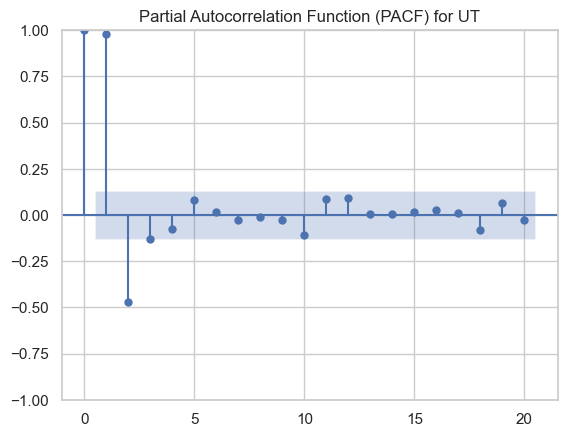

ADF Statistic for VA: -3.7183696950765626
p-value: 0.003862063258863597


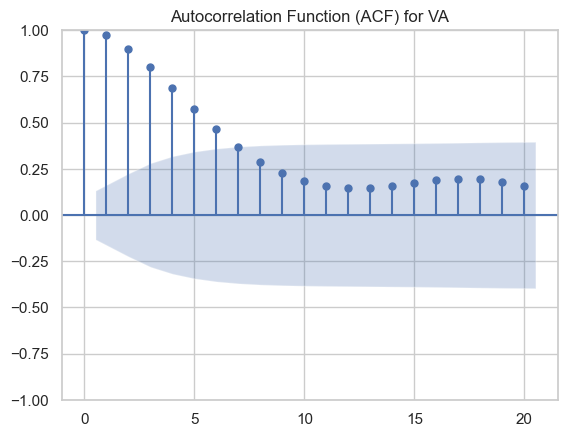

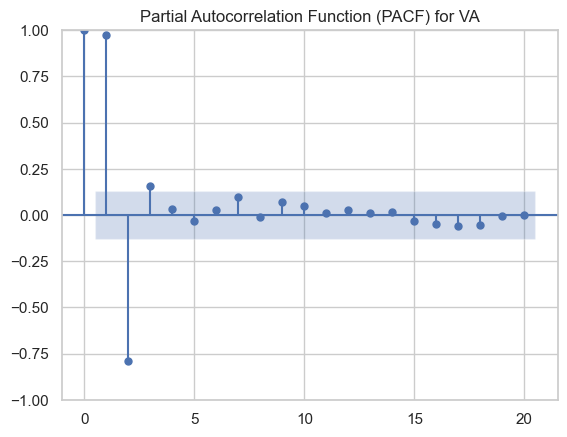

ADF Statistic for VI: -4.896135578698349
p-value: 3.548344968420234e-05


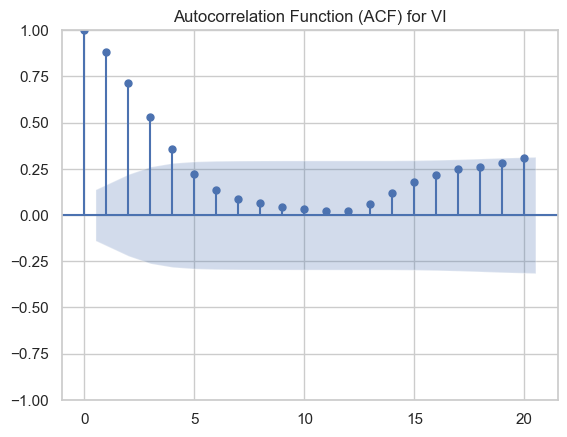

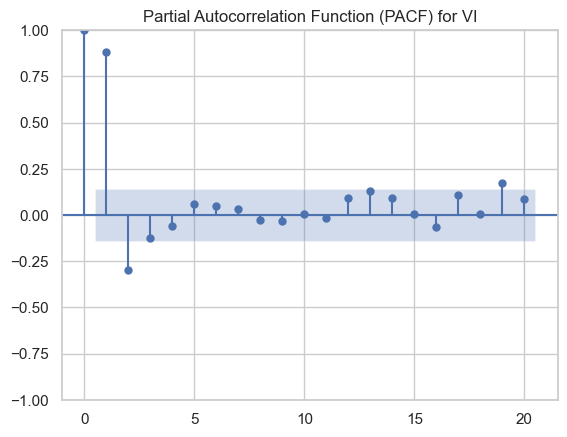

ADF Statistic for VT: -3.0861586392910034
p-value: 0.027594613261784053


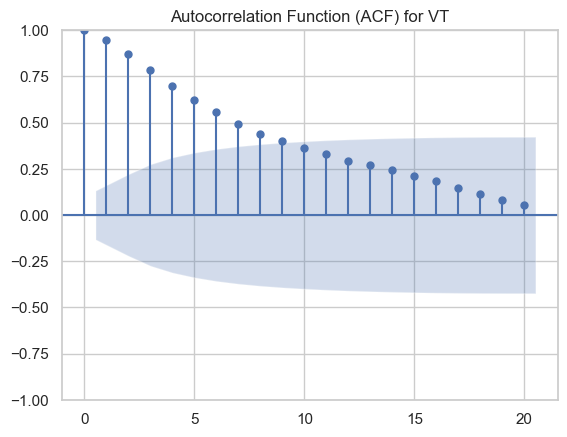

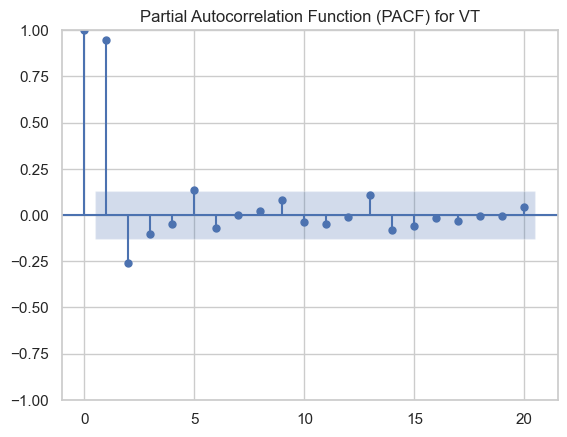

ADF Statistic for WA: -3.8045431917271033
p-value: 0.0028611727414849294


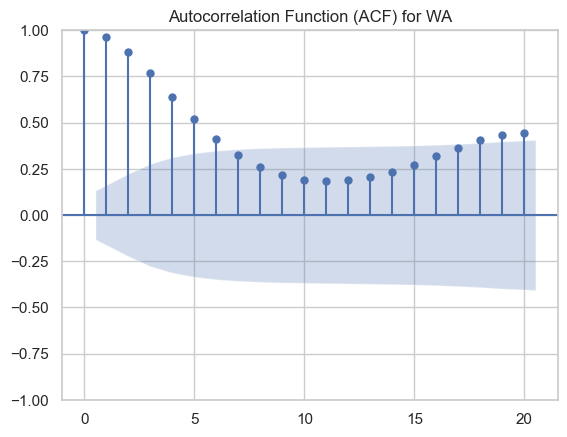

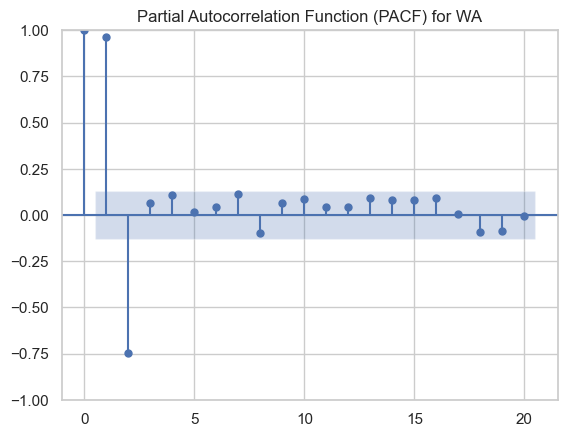

ADF Statistic for WI: -3.0380008657372666
p-value: 0.03149478889963117


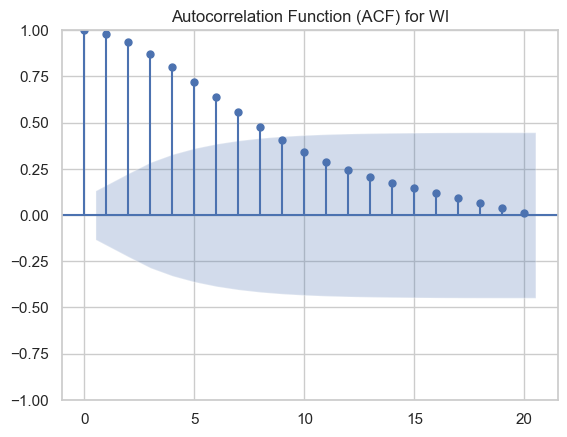

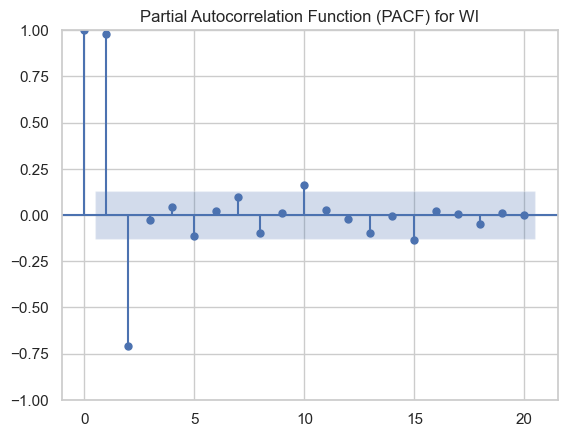

ADF Statistic for WV: -4.23615965092745
p-value: 0.0005719443514389801


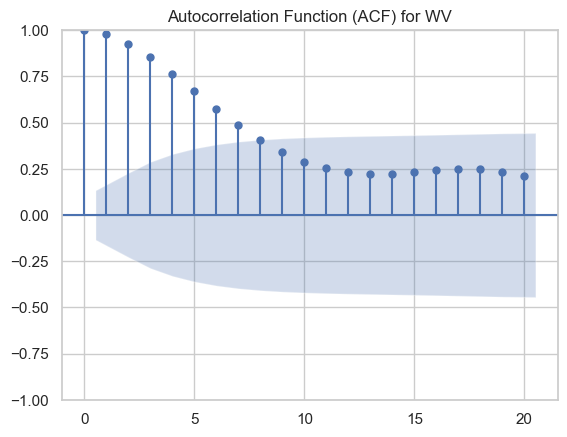

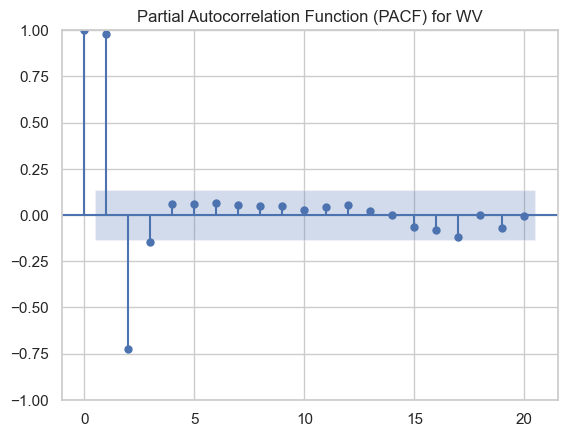

ADF Statistic for WY: -3.0460878398180893
p-value: 0.03080882684976353


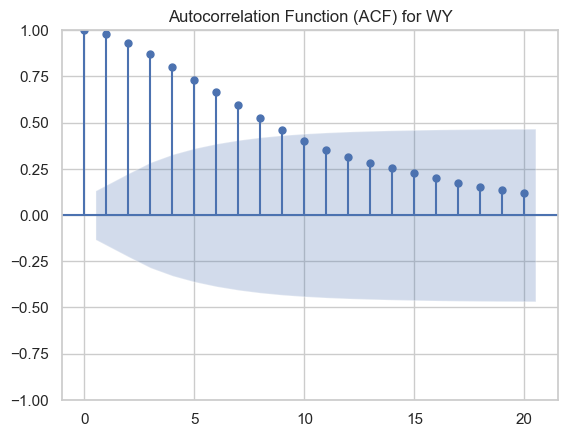

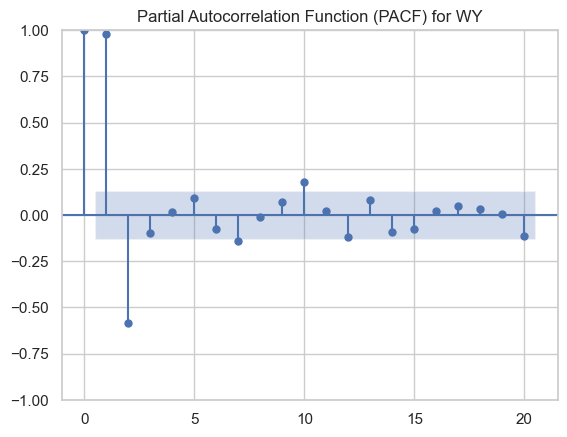

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

for region in regions:
    ts = df_model[df_model['Geographic aggregation'] == region]['COVID-19 Inpatients']
    
    # Augmented Dickey-Fuller Test for stationarity
    result = adfuller(ts)
    print(f'ADF Statistic for {region}: {result[0]}')
    print(f'p-value: {result[1]}')
    
    # Plot ACF and PACF
    plot_acf(ts, lags=20)
    plt.title(f'Autocorrelation Function (ACF) for {region}')
    plt.show()
    
    plot_pacf(ts, lags=20)
    plt.title(f'Partial Autocorrelation Function (PACF) for {region}')
    plt.show()

/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


RMSE for MA: 806.5994472757643


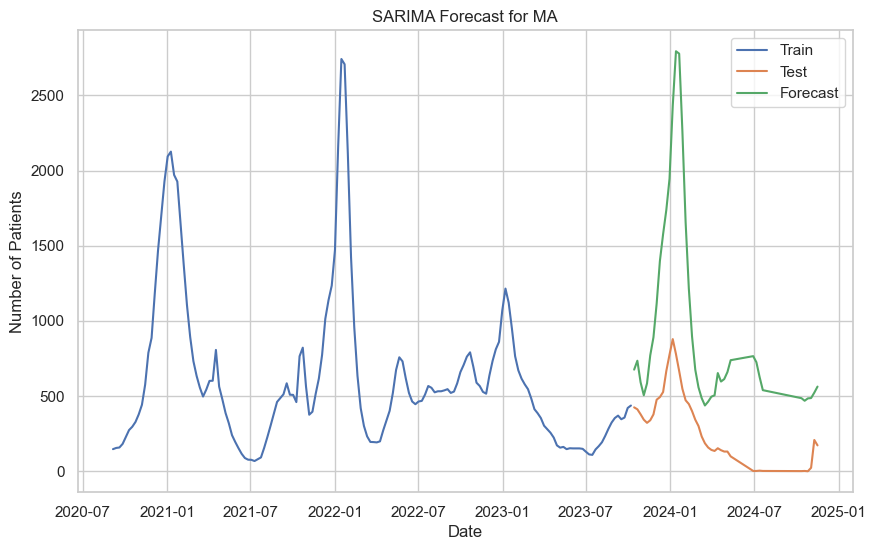

In [ ]:
# 3. Model Selection
# ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Example for one region (e.g., 'MA')
region = 'MA'
ts = df_model[df_model['Geographic aggregation'] == region]['COVID-19 Inpatients']

# Split into train and test sets
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Define and fit the SARIMA model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))  # Adjust parameters based on ACF/PACF
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE for {region}: {rmse}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title(f'SARIMA Forecast for {region}')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
11:34:12 - cmdstanpy - INFO - Chain [1] start processing
11:34:12 - cmdstanpy - INFO - Chain [1] done processing


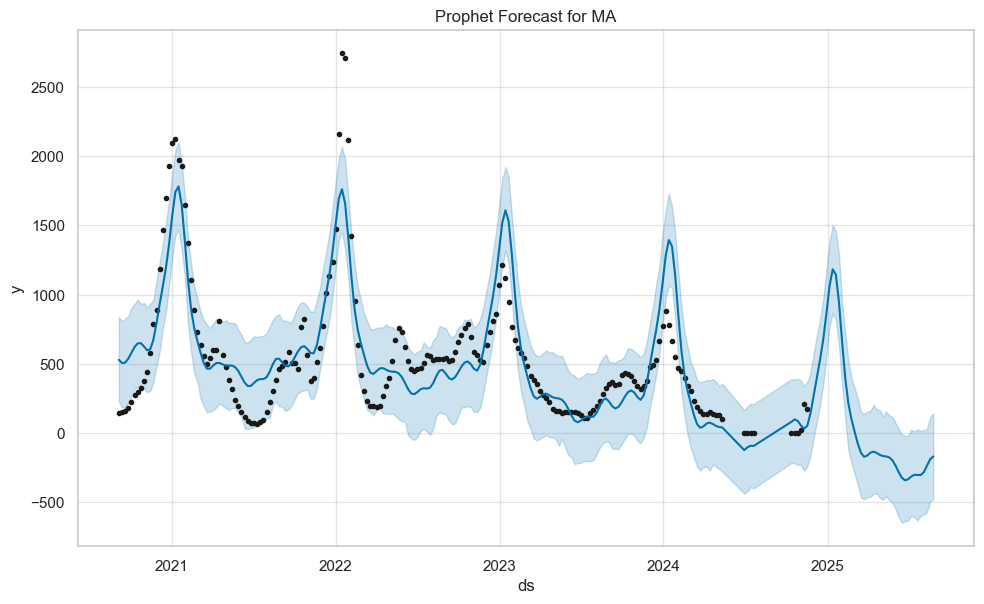

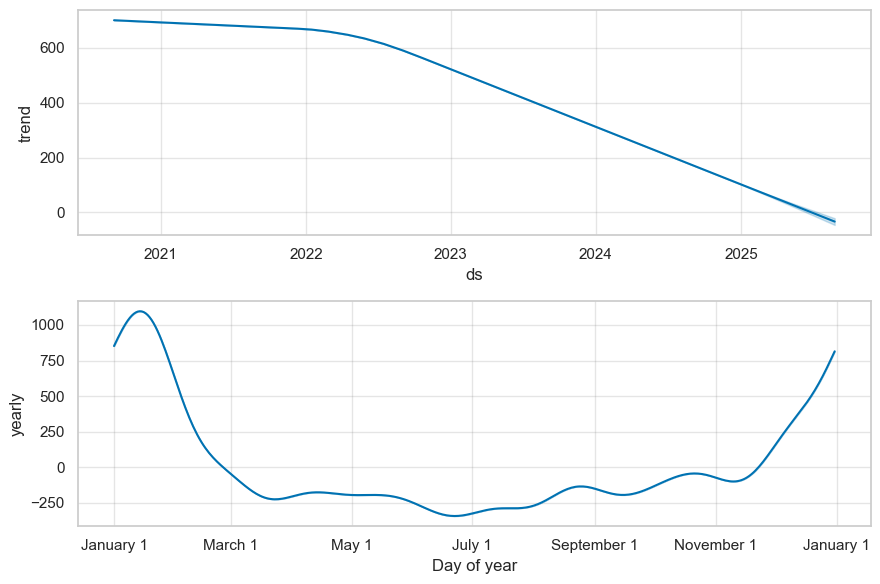

Prophet RMSE for MA: 221.02749146113516


In [25]:
# Prophet, Developed by Facebook, Prophet is user-friendly and handles seasonality and holidays well
from prophet import Prophet

# Prepare data for Prophet
df_prophet = ts.reset_index()
df_prophet = df_prophet.rename(columns={'Week Ending Date': 'ds', 'COVID-19 Inpatients': 'y'})

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=len(test), freq='W')

# Predict
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title(f'Prophet Forecast for {region}')
plt.show()

# Plot components
fig2 = model.plot_components(forecast)
plt.show()

# Evaluate
forecast_test = forecast.set_index('ds').loc[test.index]['yhat']
rmse = np.sqrt(mean_squared_error(test, forecast_test))
print(f'Prophet RMSE for {region}: {rmse}')

Random Forest RMSE for MA: 39.56008597613287
Random Forest MAE for MA: 29.231463414634142


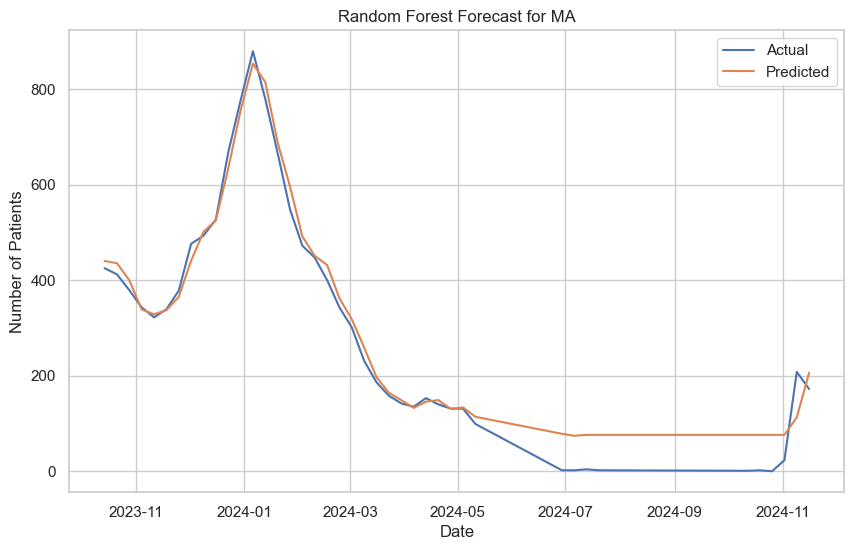

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Select features and target
features = ['lag_1', 'lag_2', 'rolling_mean_2']
target = 'COVID-19 Inpatients'

# Subset for the region
df_region = df_model[df_model['Geographic aggregation'] == region].copy()

# Define X and y
X = df_region[features]
y = df_region[target]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest RMSE for {region}: {rmse}')
print(f'Random Forest MAE for {region}: {mae}')

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title(f'Random Forest Forecast for {region}')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

In [27]:
# 4. Cross Validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Fold RMSE: {rmse}')

Fold RMSE: 107.08279177318545
Fold RMSE: 195.54281412147432
Fold RMSE: 53.79104076578802
Fold RMSE: 14.878580495993477
Fold RMSE: 43.38131101585734


In [28]:
# 5. Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best CV RMSE: {best_rmse}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tot

In [29]:
# 6. Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 32.67878787878788
MSE: 1881.9381454545457
RMSE: 43.38131101585734
MAPE: 1.0399220957746428e+16


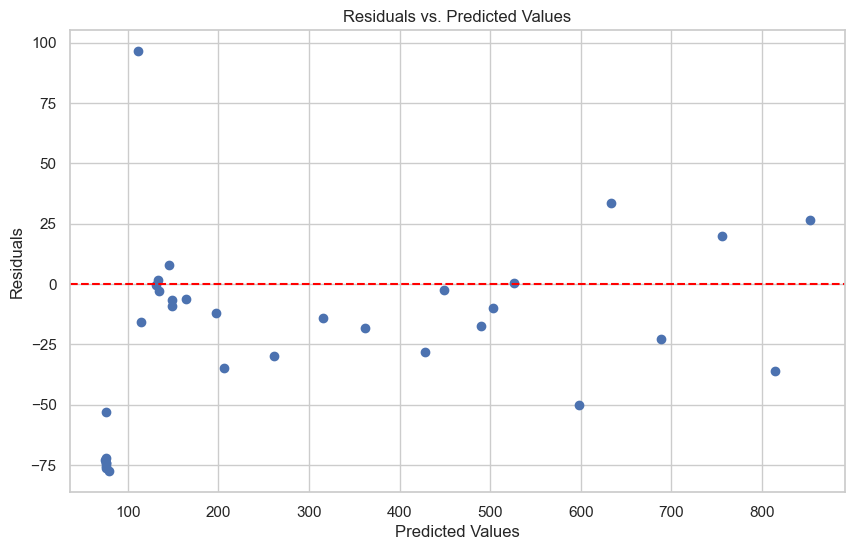

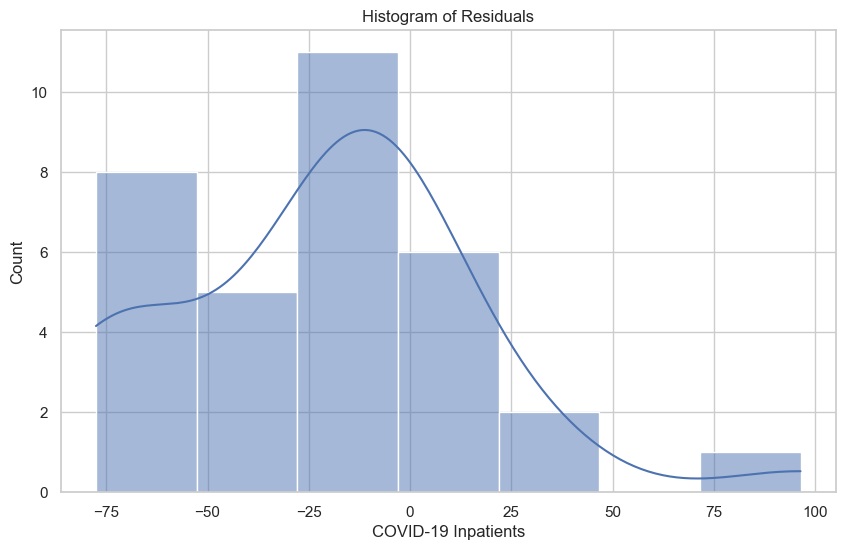

In [30]:
# Residual analysis
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

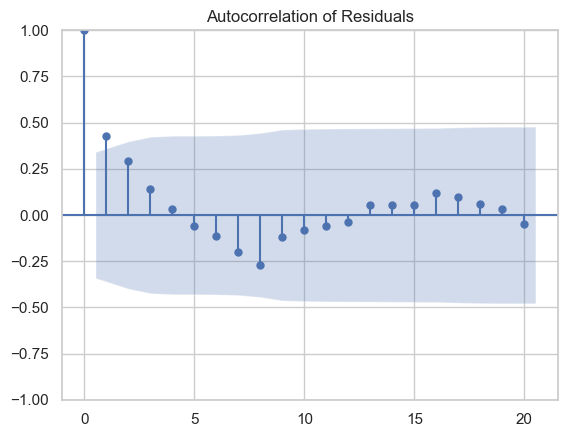

In [31]:
# Autocorrelation of Residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

In [32]:
# 7. Model Deployment
import joblib

# Save the model
joblib.dump(best_rf, 'random_forest_model_region_A.pkl')

# To load the model later
# model_loaded = joblib.load('random_forest_model_region_A.pkl')

['random_forest_model_region_A.pkl']

In [33]:
# 8. Automate the Process for All Regions
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_model(region, df_sorted, features, target, test_size=0.2):
    # Subset data for the region
    df_region = df_t[df_t['Geographic aggregation'] == region].copy()
    
    # Feature Engineering
    for lag in lag_steps:
        df_region[f'lag_{lag}'] = df_region[target].shift(lag)
    df_region['rolling_mean_2'] = df_region[target].rolling(window=2).mean()
        
    # Drop rows with NaNs
    df_region = df_region.dropna()
    
    # Define X and y
    X = df_region[features]
    y = df_region[target]
    
    # Split into train and test
    split = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {region}: {rmse}')
    
    return model, rmse

# Define features and target
features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_2']
target = 'COVID-19 Inpatients'

# Dictionary to store models and their performance
models = {}
performances = {}

# Iterate over each region
for region in regions:
    print(f'\nTraining model for region: {region}')
    model, rmse = train_model(region, df_t, features, target)
    models[region] = model
    performances[region] = rmse


Training model for region: AK
RMSE for AK: 6.684637237726517

Training model for region: AL
RMSE for AL: 51.57756438343393

Training model for region: AR
RMSE for AR: 16.496375152796997

Training model for region: AS
RMSE for AS: 0.0

Training model for region: AZ
RMSE for AZ: 38.5870616269236

Training model for region: CA
RMSE for CA: 257.57859813251

Training model for region: CO
RMSE for CO: 16.829867795083835

Training model for region: CT
RMSE for CT: 18.1790170626367

Training model for region: DC
RMSE for DC: 9.313924448714605

Training model for region: DE
RMSE for DE: 5.857037142695024

Training model for region: FL
RMSE for FL: 286.7534830493068

Training model for region: GA
RMSE for GA: 76.63809278621885

Training model for region: GU
RMSE for GU: 0.8993078146299772

Training model for region: HI
RMSE for HI: 9.135579296952606

Training model for region: IA
RMSE for IA: 9.338739938362329

Training model for region: ID
RMSE for ID: 12.17343223058835

Training model for reg

   Region         RMSE
0      AK     6.684637
1      AL    51.577564
2      AR    16.496375
3      AS     0.000000
4      AZ    38.587062
5      CA   257.578598
6      CO    16.829868
7      CT    18.179017
8      DC     9.313924
9      DE     5.857037
10     FL   286.753483
11     GA    76.638093
12     GU     0.899308
13     HI     9.135579
14     IA     9.338740
15     ID    12.173432
16     IL    46.746854
17     IN    17.690459
18     KS    11.827900
19     KY    19.562474
20     LA    30.247230
21     MA    39.902307
22     MD    32.347222
23     ME     4.888387
24     MI    41.628784
25     MN    27.578288
26     MO    40.451119
27     MP     1.751284
28     MS    15.215410
29     MT     2.549573
30     NC   130.404010
31     ND     4.818579
32     NE    11.189564
33     NH     4.502529
34     NJ    51.521827
35     NM    12.408635
36     NV    37.514869
37     NY   147.184728
38     OH    49.600821
39     OK    21.115355
40     OR    22.285358
41     PA    52.211541
42     PR  

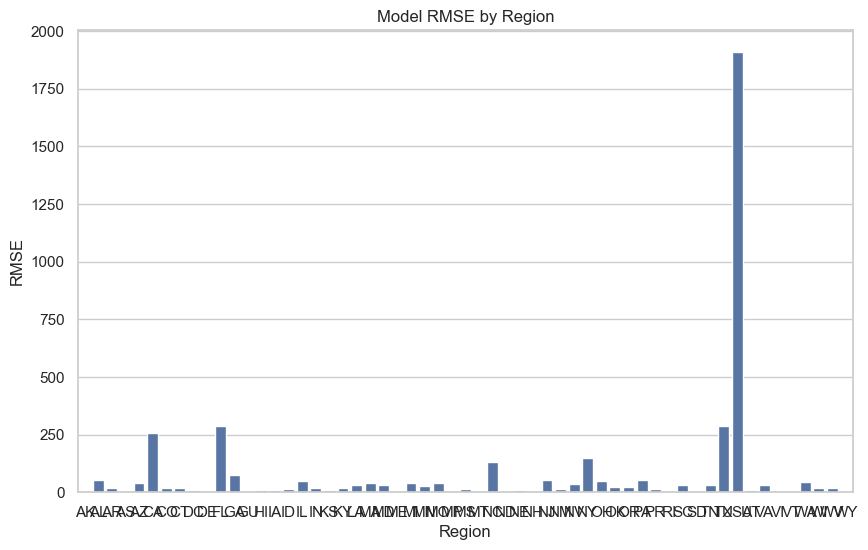

In [34]:
# 9. Model Evaluation Across Regions
# Convert performances to DataFrame for easy analysis
performance_df = pd.DataFrame(list(performances.items()), columns=['Region', 'RMSE'])
print(performance_df)

# Plot RMSE per region
plt.figure(figsize=(10,6))
sns.barplot(x='Region', y='RMSE', data=performance_df)
plt.title('Model RMSE by Region')
plt.xlabel('Region')
plt.ylabel('RMSE')
plt.show()

In [35]:
# 10. Hyperparameter Tuning for Each Region
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(region, df_t, features, target, test_size=0.2):
    # Subset data for the region
    df_region = df_t[df_t['Geographic aggregation'] == region].copy()
    
    # Feature Engineering
    for lag in lag_steps:
        df_region[f'lag_{lag}'] = df_region[target].shift(lag)
    df_region['rolling_mean_2'] = df_region[target].rolling(window=2).mean()
    
    # Drop rows with NaNs
    df_region = df_region.dropna()
    
    # Define X and y
    X = df_region[features]
    y = df_region[target]
    
    # Split into train and test
    split = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Initialize the model
    rf = RandomForestRegressor(random_state=42)
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
    
    # Initialize GridSearchCV
    # TimeSeriesSplit, incrementally expand the training set while moving forward in time for the validation set
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=TimeSeriesSplit(n_splits=3), 
                               scoring='neg_mean_squared_error',
                               n_jobs=-1, verbose=1)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Best estimator
    best_rf = grid_search.best_estimator_
    print(f'Best parameters for {region}: {grid_search.best_params_}')
    
    # Predict
    y_pred = best_rf.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Optimized RMSE for {region}: {rmse}')
    
    return best_rf, rmse

# Iterate over each region for hyperparameter tuning
for region in regions:
    print(f'\nTuning model for region: {region}')
    best_model, tuned_rmse = tune_hyperparameters(region, df_t, features, target)
    models[region] = best_model
    performances[region] = tuned_rmse


Tuning model for region: AK
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for AK: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized RMSE for AK: 4.660725960327718

Tuning model for region: AL
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for AL: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Optimized RMSE for AL: 62.42648607506085

Tuning model for region: AR
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for AR: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Optimized RMSE for AR: 18.264021652741715

Tuning model for region: AS
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for AS: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_esti

In [ ]:
# 11. Final Model Selection and Forecasting
# Once satisfied with the model’s performance on the test set, retrain it on the entire dataset to leverage all available information.
for region in regions:
    print(f'\nRetraining optimized model for region: {region}')
    df_region = df_t[df_t['Geographic aggregation'] == region].copy()
    
    # Feature Engineering
    for lag in lag_steps:
        df_region[f'lag_{lag}'] = df_region[target].shift(lag)
    df_region['rolling_mean_2'] = df_region[target].rolling(window=2).mean()
    
    # Drop rows with NaNs
    df_region = df_region.dropna()
    
    # Define X and y
    X = df_region[features]
    y = df_region[target]
    
    # Retrain the best model
    best_model = models[region]
    best_model.fit(X, y)
    
    # Save the retrained model
    joblib.dump(best_model, f'random_forest_model_{region}.pkl')


Retraining optimized model for region: AK

Retraining optimized model for region: AL

Retraining optimized model for region: AR

Retraining optimized model for region: AS

Retraining optimized model for region: AZ

Retraining optimized model for region: CA

Retraining optimized model for region: CO

Retraining optimized model for region: CT

Retraining optimized model for region: DC

Retraining optimized model for region: DE

Retraining optimized model for region: FL

Retraining optimized model for region: GA

Retraining optimized model for region: GU

Retraining optimized model for region: HI

Retraining optimized model for region: IA

Retraining optimized model for region: ID

Retraining optimized model for region: IL

Retraining optimized model for region: IN

Retraining optimized model for region: KS

Retraining optimized model for region: KY

Retraining optimized model for region: LA

Retraining optimized model for region: MA

Retraining optimized model for region: MD

Retraining

In [ ]:
# Define forecasting function
def forecast_future(region, df_t, features, steps=12):
    # Get the last available data for the region
    df_region = df_t[df_t['Geographic aggregation'] == region].copy()
    last_date = df_region.index.max()
    
    # Initialize DataFrame for future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=steps, freq='W')
    future_df = pd.DataFrame({'Week Ending Date': future_dates})
    future_df['Geographic aggregation'] = region
    future_df.set_index('Week Ending Date', inplace=True)
    
    # Initialize list to store predictions
    predictions = []
    
    for date in future_dates:
        # Create a new row with time-based features
        new_row = {}
        
        # Generate lag features from the last known values
        for lag in lag_steps:
            lag_date = date - pd.Timedelta(weeks=lag)
            if lag_date in df_t.index:
                new_row[f'lag_{lag}'] = df_t.loc[lag_date, 'COVID-19 Inpatients']
            else:
                # Handle cases where lag_date is outside the data range
                new_row[f'lag_{lag}'] = df_t[df_t['Geographic aggregation'] == region]['COVID-19 Inpatients'].iloc[-1]
        
        # Calculate rolling mean
        new_row['rolling_mean_2'] = (new_row['lag_1'] + new_row['lag_2']) / 2
        
        # Create DataFrame for the new row
        X_new = pd.DataFrame([new_row], index=[date])
        
        # Predict using the trained model
        model = models[region]
        prediction = model.predict(X_new[features])[0]
        predictions.append(prediction)
        
        # Update df_sorted with the new prediction for future lags
        df_t.loc[date, 'COVID-19 Inpatients'] = prediction
    
    # Create a DataFrame for predictions
    forecast_df = pd.DataFrame({
        'Week Ending Date': future_dates,
        'Geographic aggregation': region,
        'Predicted COVID-19 Inpatients': predictions
    })
    
    return forecast_df

# Example: Forecast for 12 weeks ahead for all regions
all_forecasts = pd.DataFrame()

for region in regions:
    print(f'\nForecasting for region: {region}')
    forecast_df = forecast_future(region, df_t, features, steps=12)
    all_forecasts = pd.concat([all_forecasts, forecast_df], ignore_index=True)

print("\nFuture Predictions:")
print(all_forecasts)

# The above forecasting function iteratively uses the latest predictions to generate lag features for future predictions, ensuring temporal continuity.


Forecasting for region: AK

Forecasting for region: AL

Forecasting for region: AR

Forecasting for region: AS

Forecasting for region: AZ

Forecasting for region: CA

Forecasting for region: CO

Forecasting for region: CT

Forecasting for region: DC

Forecasting for region: DE

Forecasting for region: FL

Forecasting for region: GA

Forecasting for region: GU

Forecasting for region: HI

Forecasting for region: IA

Forecasting for region: ID

Forecasting for region: IL

Forecasting for region: IN

Forecasting for region: KS

Forecasting for region: KY

Forecasting for region: LA

Forecasting for region: MA

Forecasting for region: MD

Forecasting for region: ME

Forecasting for region: MI

Forecasting for region: MN

Forecasting for region: MO

Forecasting for region: MP

Forecasting for region: MS

Forecasting for region: MT

Forecasting for region: NC

Forecasting for region: ND

Forecasting for region: NE

Forecasting for region: NH

Forecasting for region: NJ

Forecasting for reg

In [ ]:

# 12. Model Monitoring and Maintenance
# 13. Documentation and Reproducibility